In [1]:
import networkx as nx
import osmnx as ox
import requests
import pandas as pd
import numpy as np
import math
import sys
import json

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.15.0'

## Relevant stuff
https://www.mdpi.com/journal/sustainability/special_issues/Operations_Logistics
https://ladeatlas.elektromobilitaet-bayern.de/
https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/HandelundVertrieb/Ladesaeulenkarte/Karte/Ladesaeulenkarte-node.html;jsessionid=7CF4CE2CE5076FAC7C1D031223DB5EFF
https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Aktuell/zaehl_aktuell_node.html;jsessionid=9F7B70710F5242ABBD5508F2C32A812C.live11294?cms_map=1&cms_filter=true&cms_jahr=Jawe2018&cms_land=9&cms_strTyp=A&cms_str=&cms_dtvKfz=&cms_dtvSv=

## Custom Plotting Logic

In [2]:
def get_colors(n, cmap="viridis", start=0.0, stop=1.0, alpha=1.0, return_hex=False):
    """
    Get n evenly-spaced colors from a matplotlib colormap.
    Parameters
    ----------
    n : int
        number of colors
    cmap : string
        name of a matplotlib colormap
    start : float
        where to start in the colorspace
    stop : float
        where to end in the colorspace
    alpha : float
        opacity, the alpha channel for the RGBa colors
    return_hex : bool
        if True, convert RGBa colors to HTML-like hexadecimal RGB strings. if
        False, return colors as (R, G, B, alpha) tuples.
    Returns
    -------
    color_list : list
    """
    color_list = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    if return_hex:
        color_list = [colors.to_hex(c) for c in color_list]
    else:
        color_list = [(r, g, b, alpha) for r, g, b, _ in color_list]
    return color_list

In [3]:
def _get_colors_by_value(vals, num_bins, cmap, start, stop, na_color, equal_size):
    """
    Map colors to the values in a series.
    Parameters
    ----------
    vals : pandas.Series
        series labels are node/edge IDs and values are attribute values
    num_bins : int
        if None, linearly map a color to each value. otherwise, assign values
        to this many bins then assign a color to each bin.
    cmap : string
        name of a matplotlib colormap
    start : float
        where to start in the colorspace
    stop : float
        where to end in the colorspace
    na_color : string
        what color to assign to missing values
    equal_size : bool
        ignored if num_bins is None. if True, bin into equal-sized quantiles
        (requires unique bin edges). if False, bin into equal-spaced bins.
    Returns
    -------
    color_series : pandas.Series
        series labels are node/edge IDs and values are colors
    """
    if len(vals) == 0:
        raise ValueError("There are no attribute values.")

    if num_bins is None:
        # calculate min/max values based on start/stop and data range
        vals_min = vals.dropna().min()
        vals_max = vals.dropna().max()
        full_range = (vals_max - vals_min) / (stop - start)
        full_min = vals_min - full_range * start
        full_max = full_min + full_range

        # linearly map a color to each attribute value
        normalizer = colors.Normalize(full_min, full_max)
        scalar_mapper = cm.ScalarMappable(normalizer, cm.get_cmap(cmap))
        color_series = vals.map(scalar_mapper.to_rgba)
        color_series.loc[pd.isnull(vals)] = na_color

    else:
        # otherwise, bin values then assign colors to bins
        cut_func = pd.qcut if equal_size else pd.cut
        bins, intervals = cut_func(vals, num_bins, labels=range(num_bins), retbins=True)
        bin_colors = get_colors(num_bins, cmap, start, stop)
        color_list = [bin_colors[b] if pd.notnull(b) else na_color for b in bins]
        color_series = pd.Series(color_list, index=bins.index)

    return color_series, bin_colors, intervals

In [4]:
def get_edge_colors_by_TomTom_Attribute(G, requestedTime="16:00", requestedAttribute="travelSpeed",num_bins=None, cmap="viridis", start=0, stop=1, na_color="none", equal_size=False):

    out = {}
    
    edge_info = {k:v for k,v in nx.get_edge_attributes(G, "tomtomData").items()}
    for edge, data in edge_info.items():
        if not bool(data):
            out.update({edge: None})
        else:
            if requestedTime in data:
                out.update({edge: data[requestedTime][requestedAttribute]})
            else:
                out.update({edge: None})

    vals = pd.Series(out)
    return _get_colors_by_value(vals,num_bins, cmap, start, stop, na_color, equal_size)

In [5]:
def plotRelevantEdges(edgeList):
    ec = ['y' if edge in edgeList else 'darkblue' for edge in G.edges()]
    fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12), bgcolor = "#061529")

def plotRelevantNodes(nodeList):
    nc = ['y' if node in nodeList else 'none' for node in G.nodes()]
    fig, ax = ox.plot_graph(G, node_color=nc, edge_linewidth=1, node_size=20, figsize=(12,12), bgcolor = "#061529")

# Network Retrieval - RUNNING THESE CELLS WILL RE-DOWNLOAD THE NETWORK

# get a graph for some city
G = ox.graph_from_place('Germany', custom_filter=f'["highway"]["area"!~"yes"]["highway"~"motorway"]')
fig, ax = ox.plot_graph(G)

# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath='./data/germany_highways.gpkg')
ox.save_graphml(G, filepath='./data/germany_highways.graphml')

In [ ]:
# Network Import &  Preparation

In [8]:
G = ox.load_graphml(filepath='./data/germany_highways.graphml')

In [9]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m / 1000000

394902.3047708355

In [10]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 37032,
 'm': 44854,
 'k_avg': 2.422445452581551,
 'intersection_count': 23599,
 'streets_per_node_avg': 2.2709278461870817,
 'streets_per_node_counts': {0: 0, 1: 13433, 2: 343, 3: 23050, 4: 202, 5: 4},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.3627403326852452,
  2: 0.009262259667314756,
  3: 0.6224346511125513,
  4: 0.005454741844890905,
  5: 0.00010801468999783971},
 'edge_length_total': 31496099.516000107,
 'edge_length_avg': 702.1915440317498,
 'street_length_total': 31163197.369999964,
 'street_length_avg': 741.5218524246886,
 'street_segments_count': 42026,
 'node_density_km': 0.09377509209901908,
 'intersection_density_km': 0.05975908399343139,
 'edge_density_km': 79.75668699699666,
 'street_density_km': 78.91368825533743,
 'circuity_avg': 1.0548963891337588,
 'self_loop_proportion': 0.00020065100102554956,
 'clean_intersection_count': 20685,
 'clean_intersection_density_km': 0.05238004374779136}

# Data Import & Preparation

In [17]:
# load data
df_verkehr = pd.read_csv("./data/verkehrszaehlung2018_komplett.csv", sep=";", encoding = "ISO-8859-1", decimal=",")

# filter data
df_verkehr = df_verkehr[df_verkehr["Str_Kl"] == "A"]

In [18]:
# adjust format for coordinates
df_verkehr["latitude"] = df_verkehr["Koor_WGS84_N"].apply(lambda x: float(x))
df_verkehr["longitude"] = df_verkehr["Koor_WGS84_E"].apply(lambda x: float(x))

In [19]:
# fix formatting issues with numeric values (datasets contain stupid formatting like 5.357.432 instead of 5357432.00)
df_verkehr["DTV_Kfz_MobisSo_Q"] = df_verkehr["DTV_Kfz_MobisSo_Q"].apply(lambda x: float(str(x).replace(".", "")))
df_verkehr["DTV_SV_MobisSo_Q"] = df_verkehr["DTV_SV_MobisSo_Q"].apply(lambda x: float(str(x).replace(".", "")))

In [20]:
# remove rows with NA values
df_verkehr = df_verkehr[df_verkehr['DTV_Kfz_MobisSo_Q'].notna()]

## Populate Network with traffic data

In [21]:
# set default values for every edge (initialize) which are later overwritten for relevant edges
nx.set_node_attributes(G, "", "roadname")
nx.set_node_attributes(G, 0, "quantity_cars")
nx.set_node_attributes(G, 0, "quantity_trucks")
nx.set_node_attributes(G, "", "general_direction")
nx.set_node_attributes(G, "", "current_location")

counter = 0
total = 0
nodes_with_data = []
for idx, row in df_verkehr.iterrows():
    lat, lng = row["latitude"], row["longitude"]
    node, dist = ox.get_nearest_node(G, (lat,lng), return_dist=True)
    total += 1
    
    if dist < 5000:
        counter += 1
        nodes_with_data.append(node)
        
        G.nodes[node]["roadname"] = row["Str_Kl"] + str(row["Str_Nr"])
        G.nodes[node]["quantity_cars"] = row["DTV_Kfz_MobisSo_Q"] / 2 # every row in dataframe contains data for both directions --> split in half for one-directional data
        G.nodes[node]["quantity_trucks"] = row["DTV_SV_MobisSo_Q"] / 2
        G.nodes[node]["general_direction"] = row["Fernziel_Ri1"]
        G.nodes[node]["current_location"] = row["Nahziel_Ri2"]

C:\Users\pasca\Anaconda3\envs\ox\lib\site-packages\osmnx\utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(data, index=nodes, crs=crs)


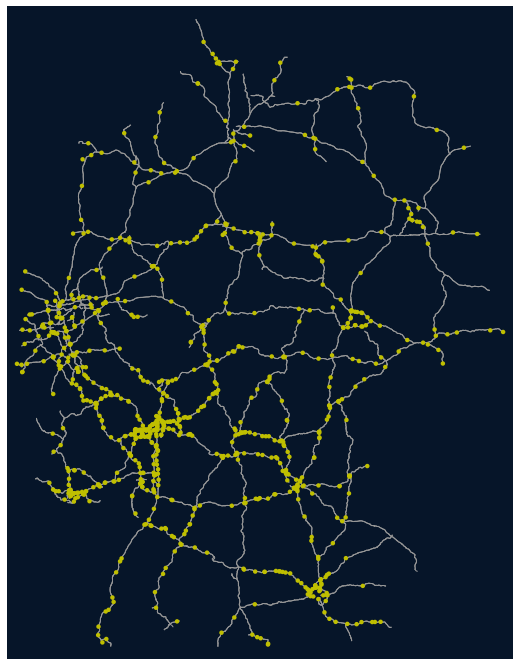

In [22]:
plotRelevantNodes(nodes_with_data)

In [23]:
nodes_without_data = [n for n in G.nodes() if G.nodes[n]["quantity_cars"] == 0]
nodes_without_data_coords = [(G.nodes[n]["y"], G.nodes[n]["y"]) for n in G.nodes() if G.nodes[n]["quantity_cars"] == 0]

nodes_with_data_coords = [(G.nodes[n]["y"], G.nodes[n]["y"]) for n in nodes_with_data]

In [24]:
nodes_with_assigned_data = [n for n in G.nodes() if G.nodes[n]["quantity_cars"] > 0]
nodes_with_na_data = [n for n in G.nodes() if G.nodes[n]["quantity_cars"] ]

In [25]:
diff_nodes = set(G.nodes()).difference(set(nodes_with_assigned_data))

In [26]:
for orig_idx, orig_node in enumerate(nodes_without_data_coords):
    nearest_node = 0
    nn_dist = 100000
    for dest_idx, dest_node in enumerate(nodes_with_data_coords):
        dist = ox.distance.great_circle_vec(*orig_node, *dest_node)
        if dist < nn_dist:
            nearest_node = nodes_with_data[dest_idx]
            nn_dist = dist
    
    orig_nodeID = nodes_without_data[orig_idx]
    G.nodes[orig_nodeID]["quantity_cars"] = G.nodes[nearest_node]["quantity_cars"]

In [27]:
nodes_without_data = [n for n in G.nodes() if G.nodes[n]["quantity_cars"] == 0]
nodes_without_data_coords = [(G.nodes[n]["y"], G.nodes[n]["y"]) for n in G.nodes() if G.nodes[n]["quantity_cars"] == 0]

nodes_with_data_coords = [(G.nodes[n]["y"], G.nodes[n]["y"]) for n in nodes_with_data]

In [28]:
nx.set_edge_attributes(G, 0, "quantity_cars")

for e in G.edges():
    n1, n2 = e
    qcars1, qcars2 = G.nodes[n1]["quantity_cars"], G.nodes[n2]["quantity_cars"]
    avg_qcars = (qcars1 + qcars2) / 2
    G.edges[(*e, 0)]["quantity_cars"] = avg_qcars

Network colored by quantity of cars per edge


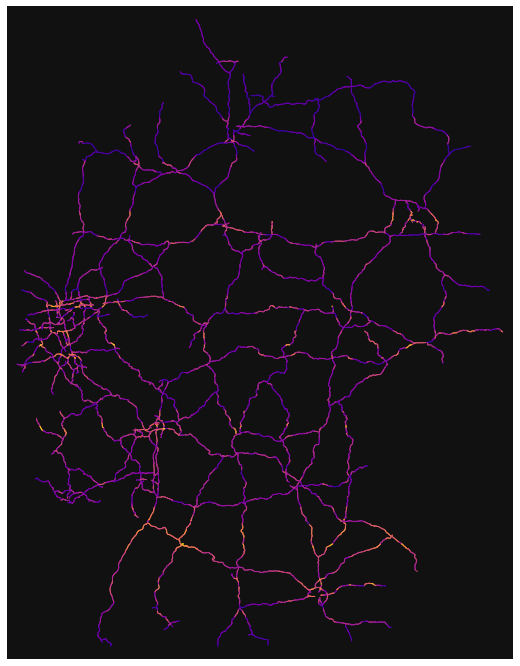

In [29]:
print("Network colored by quantity of cars per edge")
ec = ox.plot.get_edge_colors_by_attr(G, attr='quantity_cars', cmap='plasma', na_color="red", equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12))
#fig.savefig("test.png", dpi=1000)

### Identify End Nodes

In [30]:
endpoints = []
for n in G.nodes():
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways == 1:
        endpoints.append(n)

## Visualize retrieved end/startpoints

C:\Users\pasca\Anaconda3\envs\ox\lib\site-packages\osmnx\utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(data, index=nodes, crs=crs)


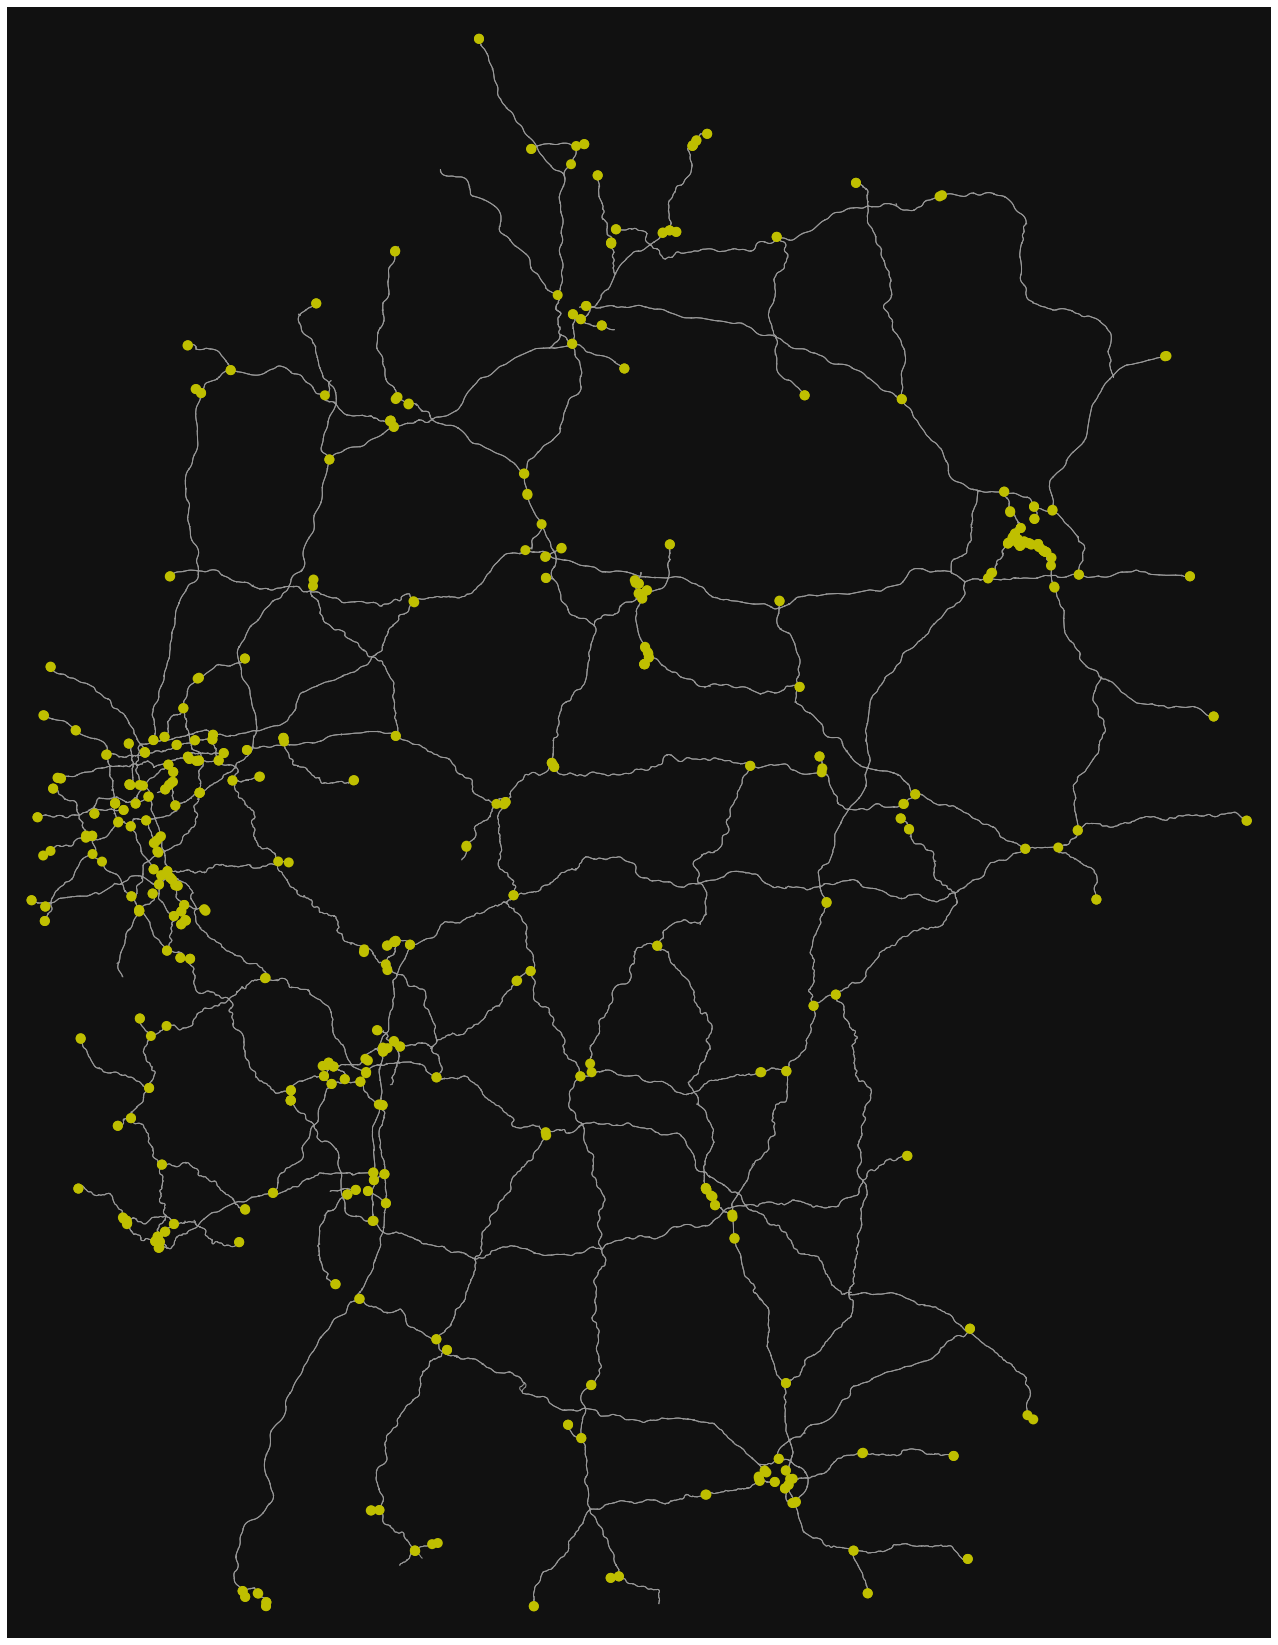

In [31]:
nc = ['y' if node in endpoints else 'none' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=100, figsize=(30,30))

#fig.savefig("endnodes.png", dpi=300)

### Dijsktra Algorithm from central point to end nodes

In [33]:
node_centralities = {k: v for k, v in sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse=True)}
central_node = next(iter(node_centralities))

In [34]:
routes = []
failed = []
for n in endpoints:
    try:
        routes.append(nx.algorithms.shortest_path(G, source=central_node, target=n, weight="length"))
    except:
        failed.append(n)
        continue

### Plot all nodes that failed --> these are nodes at the endpoints, but in the wrong direction!

C:\Users\pasca\Anaconda3\envs\ox\lib\site-packages\osmnx\utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(data, index=nodes, crs=crs)


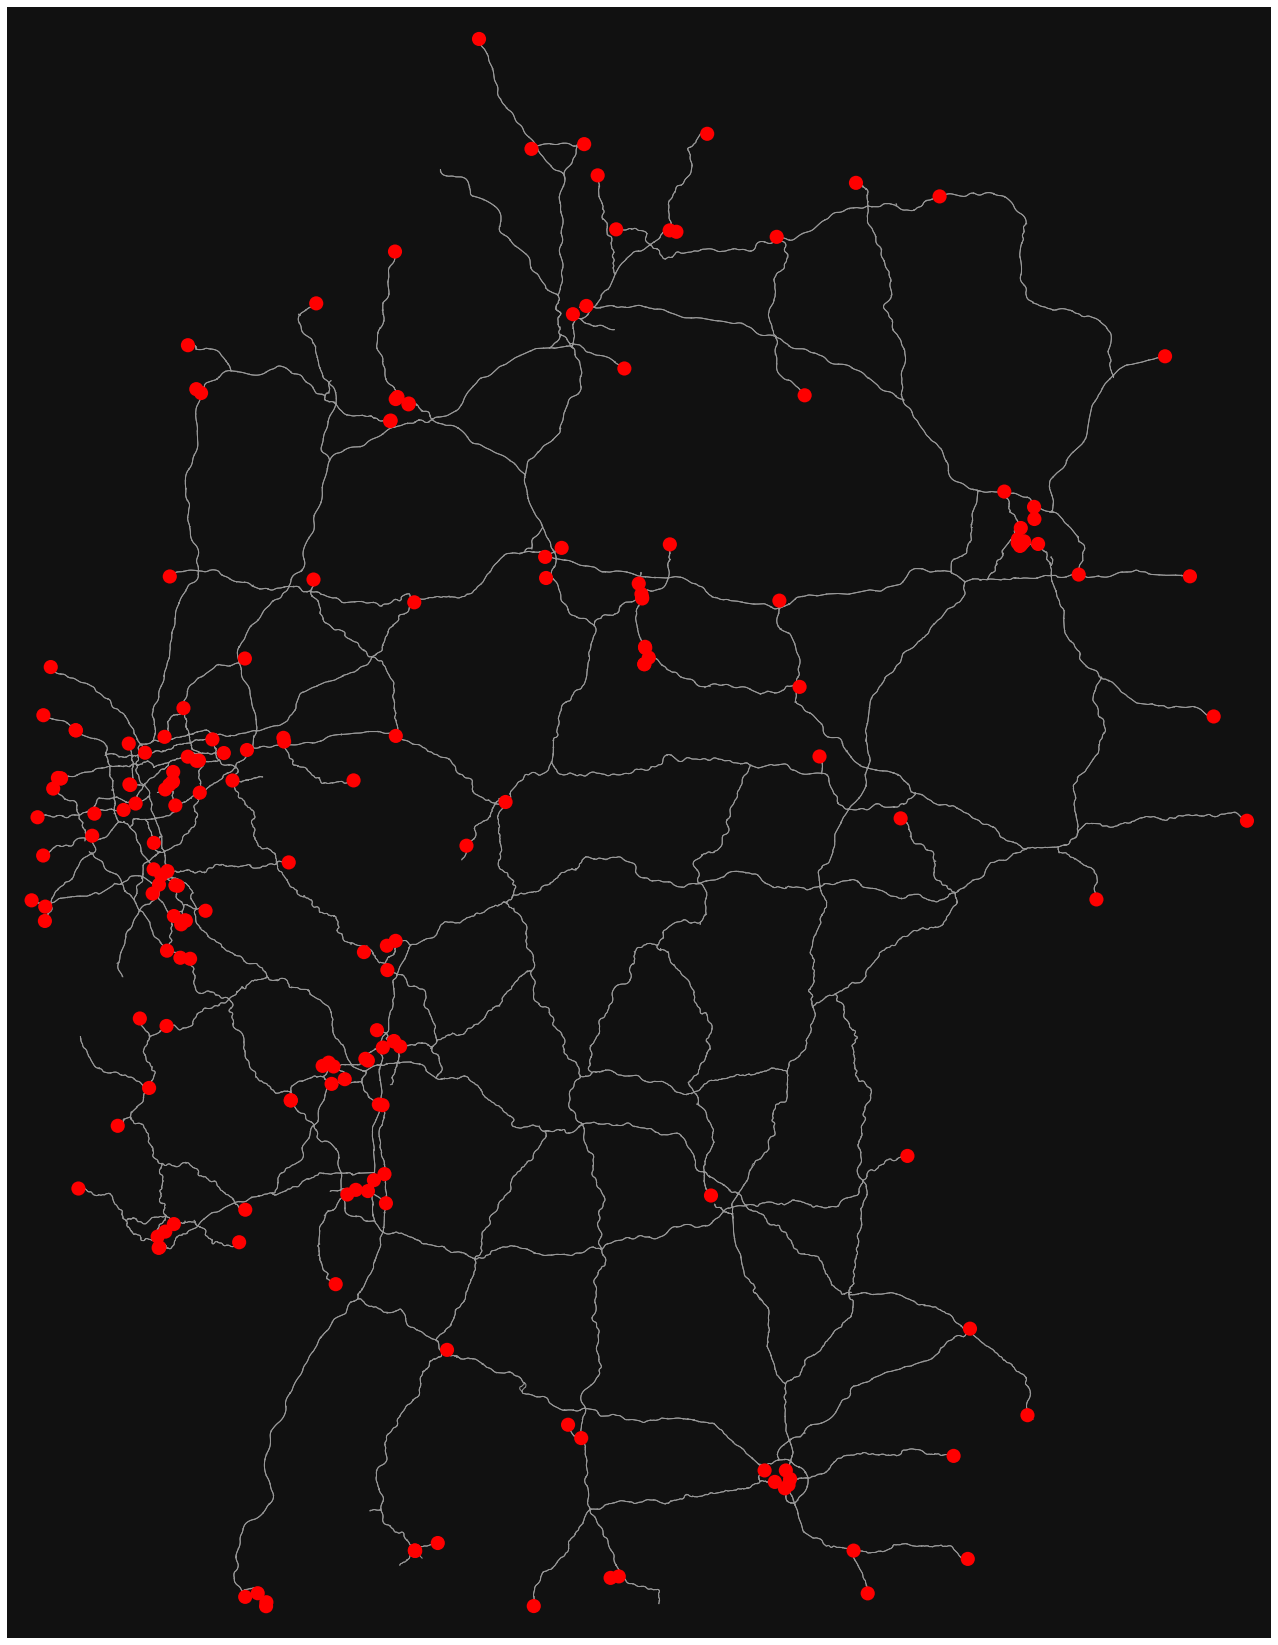

In [35]:
nc = ['r' if node in failed else 'none' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=200, figsize=(30,30))

### Plot all retrieved routes

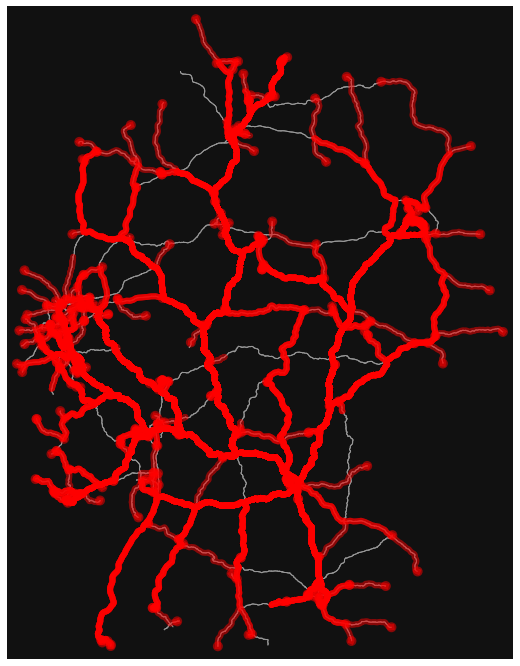

In [36]:
fig, ax = ox.plot_graph_routes(G, routes=routes,
                               route_linewidth=6, node_size=0, figsize=(12,12))

### Resolve previously failed paths due to bidirectional lanes --> Now from endpoint to central point

In [37]:
remaining_routes = []
still_fail = []
for n in failed:
    try:
        remaining_routes.append(nx.algorithms.shortest_path(G, source=n, target=central_node, weight="length"))
    except:
        still_fail.append(n)
        continue

### Combine routes from both points + other directions

In [38]:
all_routes = routes + remaining_routes

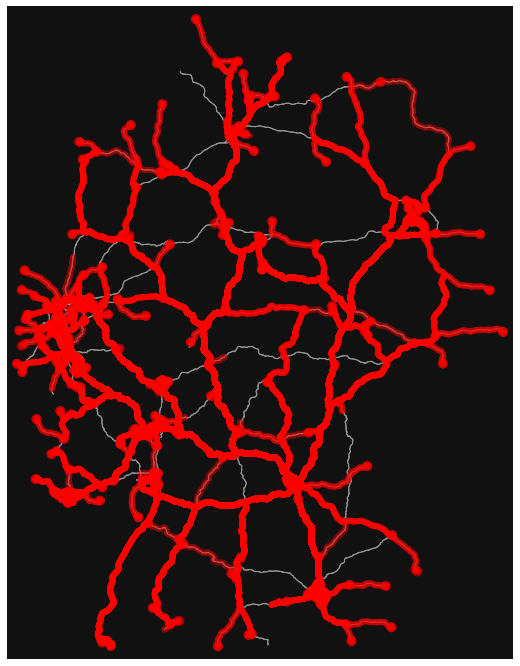

In [39]:
fig, ax = ox.plot_graph_routes(G, routes=all_routes,
                               route_linewidth=6, node_size=0, figsize=(12,12))

In [40]:
flattened_list = [y for x in all_routes for y in x]

In [41]:
# makes no sense --> observation: routes only connect via motorway_link nodes
nodes_in_routes = set(flattened_list)

nodes_in_routes_nolinks = []
for n in nodes_in_routes:
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways > 0:
        nodes_in_routes_nolinks.append(n)

In [42]:
relevant_nodes = [] # relevant is every node which has a connection to a motorway
for n in G.nodes():
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways > 0:
        relevant_nodes.append(n)

In [43]:
currently_not_used = set(relevant_nodes).difference(nodes_in_routes_nolinks); print(len(currently_not_used))

3630


C:\Users\pasca\Anaconda3\envs\ox\lib\site-packages\osmnx\utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(data, index=nodes, crs=crs)


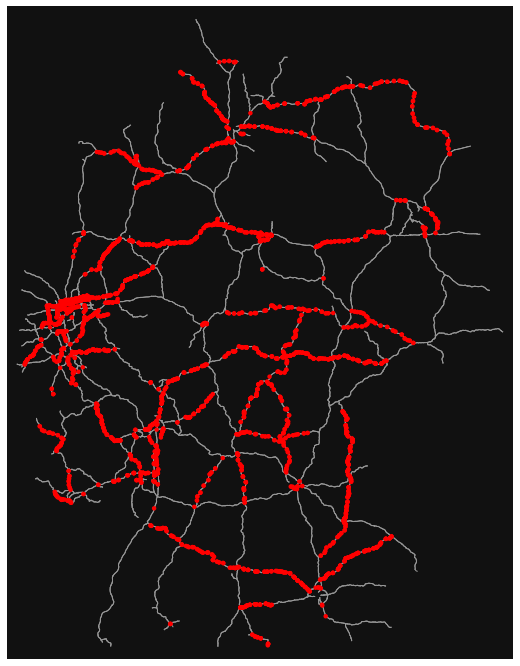

In [44]:
nc = ['r' if node in currently_not_used else 'none' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, figsize=(12,12))

In [45]:
# identify end points
new_endpoints = []
for node in currently_not_used: # check all nodes that are not currently on any route
    
    for e in G.out_edges(node): # check all edges of current node
        n1, n2 = e # unpack both nodes of edge (start, end)
        if n1 == node: # we only need to check edge node that is not our currentNode
            currentOtherNode = n2
        else:
            currentOtherNode = n1
        
        if currentOtherNode in nodes_in_routes_nolinks: # if we find an opposing edge node that is already in a route, we identified a new endpoint
            new_endpoints.append(currentOtherNode)

In [46]:
# identify end points
new_startpoints = []
for node in currently_not_used: # check all nodes that are not currently on any route
    
    for e in G.in_edges(node): # check all edges of current node
        n1, n2 = e # unpack both nodes of edge (start, end)
        if n1 == node: # we only need to check edge node that is not our currentNode
            currentOtherNode = n2
        else:
            currentOtherNode = n1
        
        if currentOtherNode in nodes_in_routes_nolinks: # if we find an opposing edge node that is already in a route, we identified a new endpoint
            new_startpoints.append(currentOtherNode)

In [47]:
# follow along an edge node by noode to identify endpoint
# endpoint is a point that is either already in previous routes or in newly identified endpoints
def recursiveEdges(node):
    for e in G.out_edges(node):
            if G.edges[(*e, 0)]["highway"] == "motorway":
                n1, currentNode = e
                
                if currentNode in new_endpoints or currentNode in nodes_in_routes_nolinks:
                    return currentNode
                else:
                    if currentNode in currently_not_used:
                        return recursiveEdges(currentNode)

In [48]:
missing_endpoints = {}
fail_nodes = []
for node in new_startpoints:
    if recursiveEdges(node) == None:
        fail_nodes.append(node)
    else:
        missing_endpoints[node] = recursiveEdges(node)

C:\Users\pasca\Anaconda3\envs\ox\lib\site-packages\osmnx\utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(data, index=nodes, crs=crs)


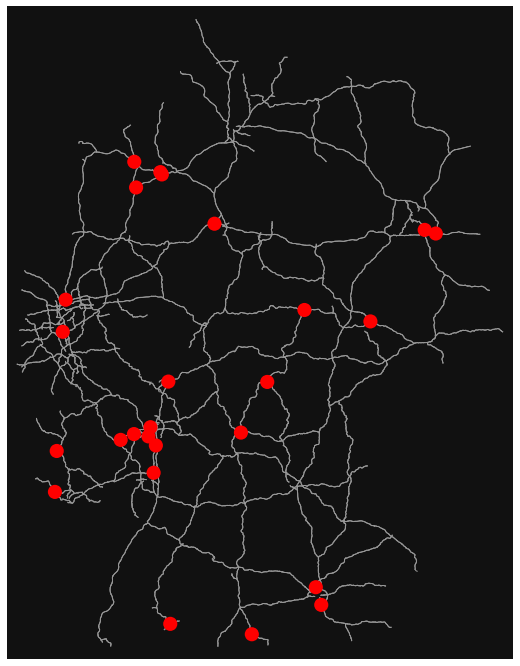

In [49]:
nc = ['r' if node in fail_nodes else 'none' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=200, figsize=(12,12))

In [50]:
missing_routes = []
for k, v in missing_endpoints.items():
    missing_routes.append(nx.shortest_path(G, source = k, target = v, weight = "length"))

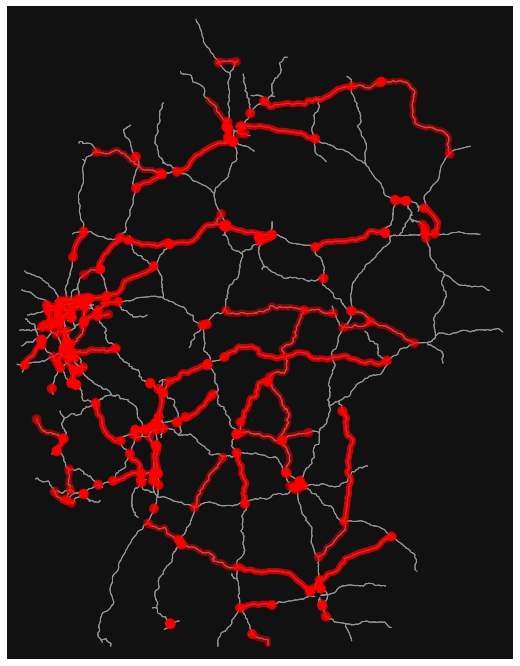

In [51]:
fig, ax = ox.plot_graph_routes(G, routes=missing_routes,
                               route_linewidth=6, node_size=0, figsize=(12,12))

In [52]:
all_relevant_paths = all_routes + missing_routes

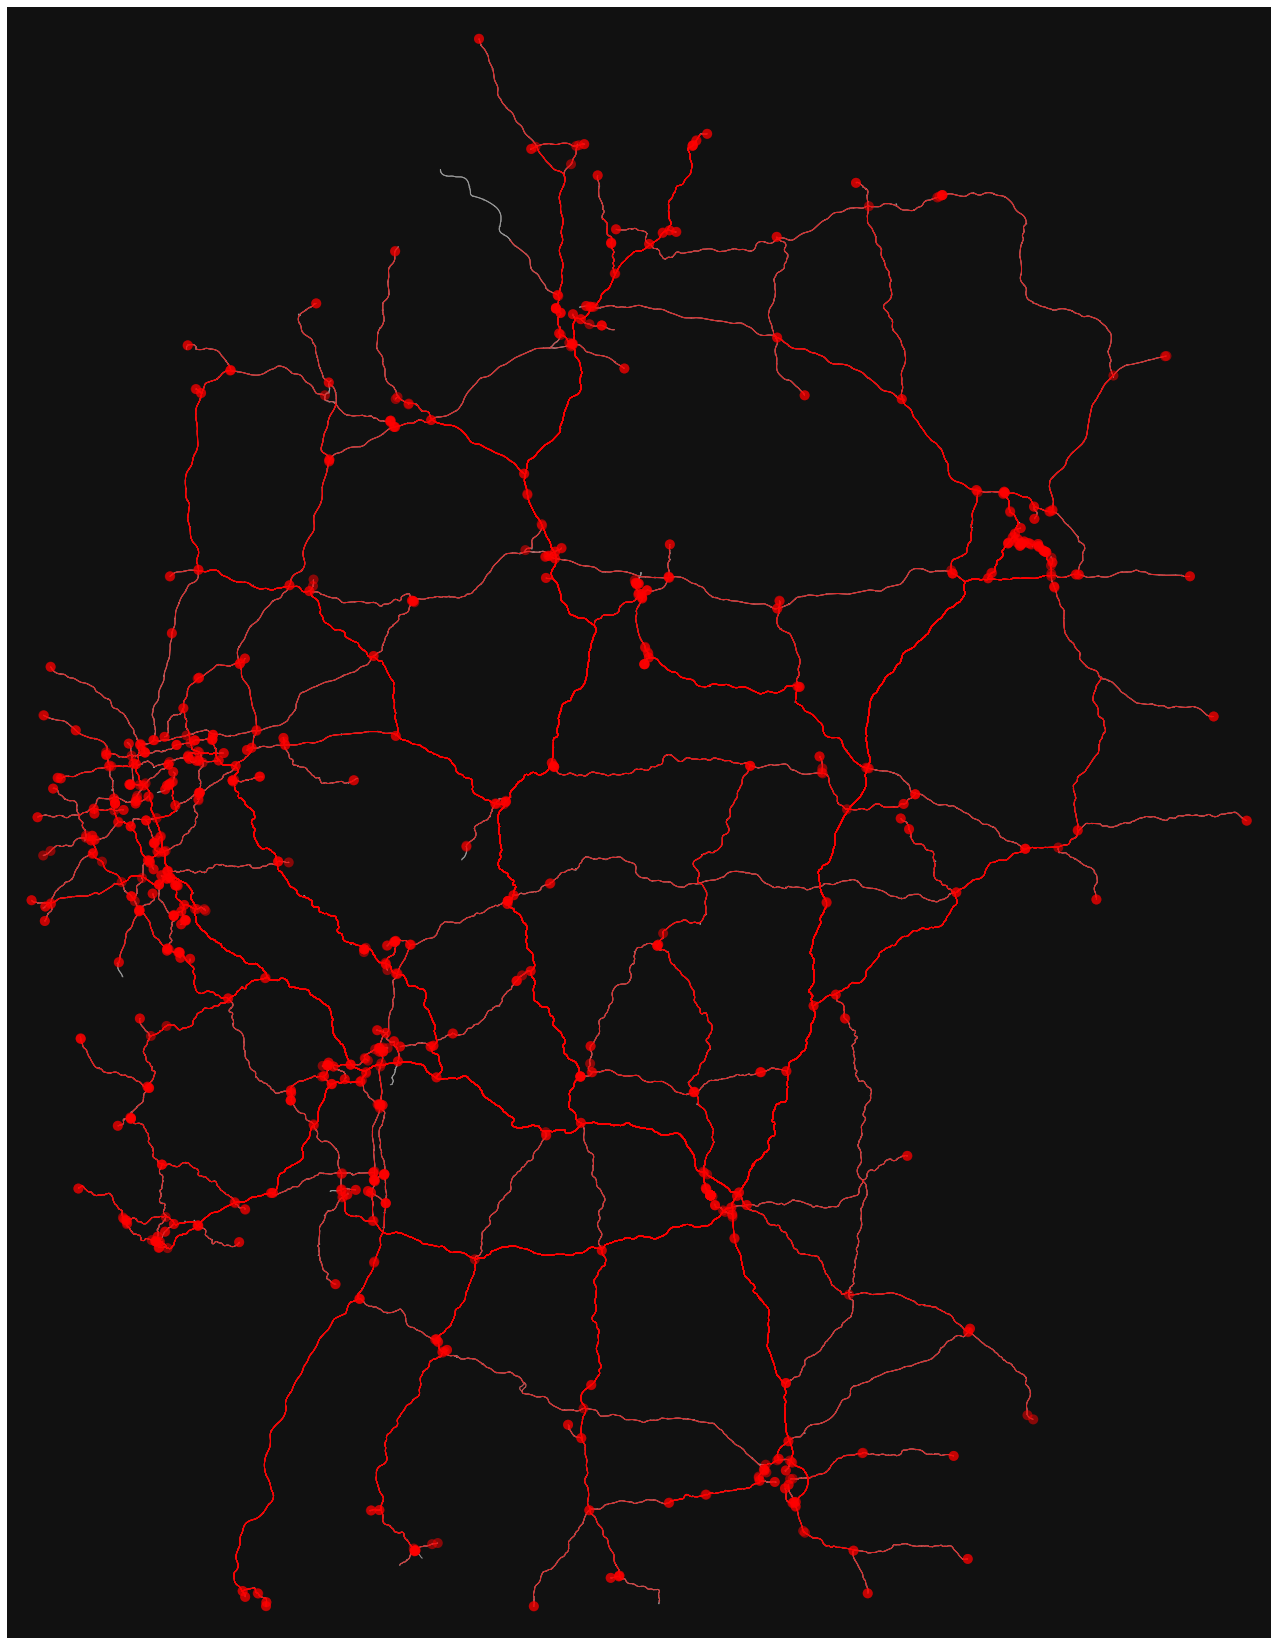

In [53]:
fig, ax = ox.plot_graph_routes(G, routes=all_relevant_paths,
                               route_linewidth=1, node_size=0, figsize=(30,30))
#fig.savefig("all_relevant_paths.png", dpi=500)

In [54]:
nx.set_edge_attributes(G, 0, "visited")
for route in all_relevant_paths:
    for i in range(len(route) - 1):
        G.edges[(route[i], route[i+1], 0)]["visited"] = 1
        

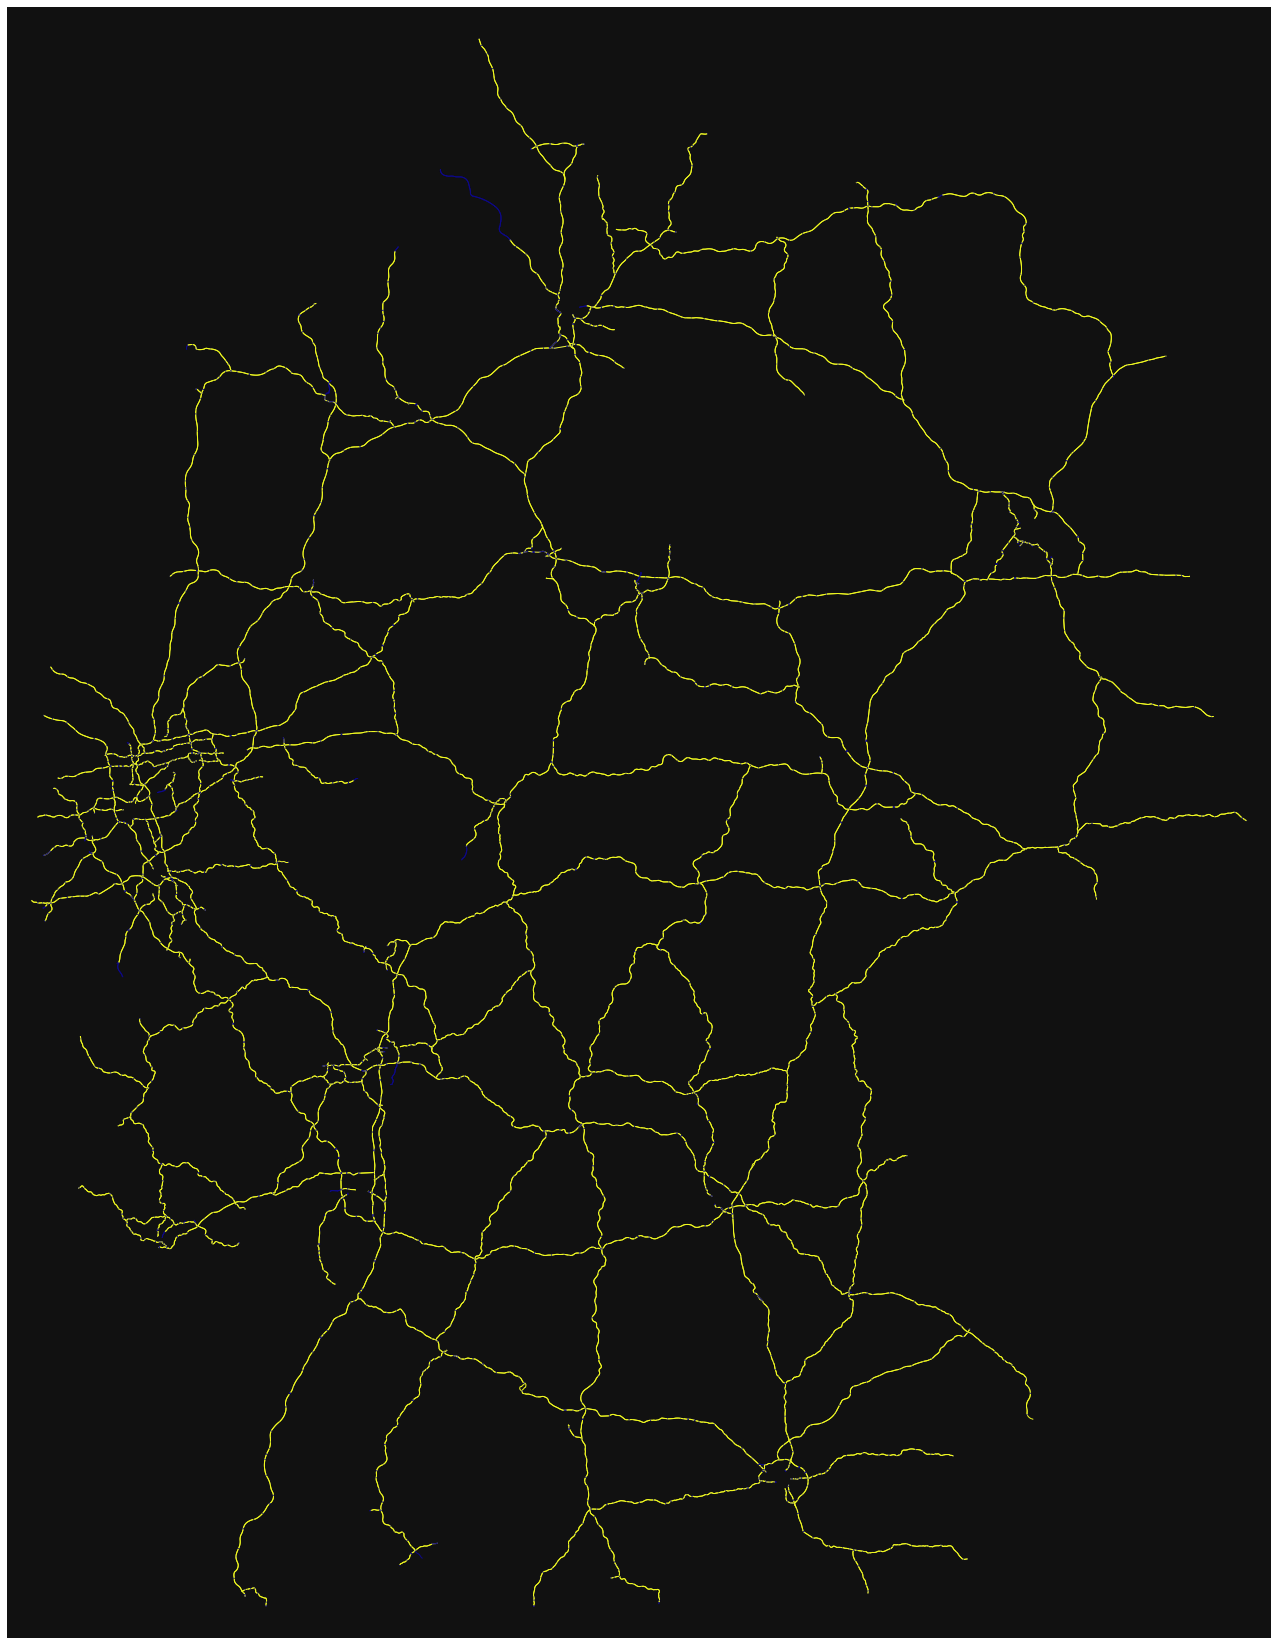

In [55]:
ec = ox.plot.get_edge_colors_by_attr(G, attr='visited', cmap='plasma', na_color="red")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(30,30))
#fig.savefig("test.png", dpi=1000)

In [56]:
# makes no sense --> observation: routes only connect via motorway_link nodes
flattened_list = [y for x in all_relevant_paths for y in x]
nodes_in_routes = set(flattened_list); print("Nodes in current routes (incl. Motorway Links): ", len(nodes_in_routes))

nodes_in_routes_nolinks = []
for n in nodes_in_routes:
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways > 0:
        nodes_in_routes_nolinks.append(n)
print("Motorway Nodes in current routes (w/o Motorwy links) ", len(nodes_in_routes_nolinks))

Nodes in current routes (incl. Motorway Links):  14900
Motorway Nodes in current routes (w/o Motorwy links)  13597


In [57]:
relevant_nodes = [] # relevant is every node which has a connection to a motorway
for n in G.nodes():
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways > 0:
        relevant_nodes.append(n)

print("Total amount of relevant motorway nodes in network: ", len(relevant_nodes))

Total amount of relevant motorway nodes in network:  13763


In [58]:
currently_not_used = set(relevant_nodes).difference(nodes_in_routes_nolinks); print("# of relevant nodes currently not on any route: ", len(currently_not_used))

# of relevant nodes currently not on any route:  166


# Save results to CSV for use with TomTom API

In [52]:
import math

In [53]:
route_output = []
circle_rad = 20

dist_threshold = 100 # minimum air distance between two coordinate pairs 
for route in all_relevant_paths:
    
    start = route[0]
    end = route[-1]

    start_coords = (G.nodes[start]["y"], G.nodes[start]["x"])
    end_coords = (G.nodes[end]["y"], G.nodes[end]["x"])

    out_str = ""
    leg_list = []
    
    prev_point = start_coords
    for n in route:
        for e in G.in_edges(n):
            curr_coords = (G.nodes[n]["y"], G.nodes[n]["x"])
            if (G.edges[(*e, 0)]["highway"] == "motorway_link" and ox.distance.great_circle_vec(*prev_point, *curr_coords) >= dist_threshold) or n == start or n == end:
                out_str = out_str + str(G.nodes[n]["y"]) + "," + str(G.nodes[n]["x"]) + ":"
                leg_list.append(n)
                prev_point = curr_coords
                break
    out_str = out_str[:-1]
    route_output.append((*start_coords, *end_coords, nx.shortest_path_length(G, start, end, weight="length"), out_str, route, leg_list))


In [54]:
import pandas as pd
dfObj = pd.DataFrame(route_output, columns = ['lat_start' , 'lng_start', 'lat_end' , 'lng_end', 'dist_in_meters', 'coord_list', 'route', "leg_list"]) 

In [55]:
dfObj.to_csv("all_routes_new.csv", index=False)

In [56]:
dfObj.head()

,lat_start,lng_start,lat_end,lng_end,dist_in_meters,coord_list,route,leg_list
0,49.4516,11.038017,48.034849,10.131776,309399.096,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."
1,49.4516,11.038017,50.001664,10.077684,124963.199,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."
2,49.4516,11.038017,47.680674,10.302760,349701.594,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."
3,49.4516,11.038017,49.361880,11.199379,49093.437,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."
4,49.4516,11.038017,49.478467,11.008066,13370.744,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."


# Load data into network

In [57]:
from os import listdir
from os.path import isfile, join

datapath = "data/tomtom"
tomtom_files = [f for f in listdir(datapath) if isfile(join(datapath, f))]

In [58]:
from dateutil.parser import parse
import datetime

def round_time(dt=None, round_to=1800):
    if dt == None: 
        dt = datetime.datetime.now()
    dt = dt.replace(tzinfo=None)
    seconds = (dt - dt.min).seconds
    rounding = (seconds+round_to/2) // round_to * round_to
    new_dt = dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)
    return '%i:%02i' % (new_dt.hour, new_dt.minute)

In [59]:
import numpy as np

## Magic! Don't touch

In [60]:
attribute_dict = {}
for e in list(G.edges()):
    attribute_dict[(*e, 0)] = {}

In [61]:
visited_paths = []
all_counter = 0

foundLegsCounter = 0
for f in tomtom_files:
    '''
        Leg = Ein Abschnitt (= Abfolge von Koordinatenpaaren), für welchen spezifische Traffic-Informationen vorliegen
        Section = Eine Aneinanderreihung von Punkten, welche auf einer Autobahn (=motorway) abgefahren werden. Eine Section kann mehrere Legs beinhalten.
        '''
    try:
        with open(join(datapath, f)) as json_file:
            # get meta data from dataset
            df_idx, _ = f.split("_")[5].split(".") # retrieve data frame index from filename
            df_idx = int(df_idx)
            df_row = dfObj.iloc[df_idx, :] # get current row by filename index
            

            # load extracted API data as json
            data = json.load(json_file)

            # add global index and leg number to every single point and save as list object
            global_idx = 0
            point_tpl = []
            for leg_idx, leg in enumerate(data["routes"][0]["legs"]): # go through every leg
                for point in leg["points"]: # go through every point in leg (point = (latitude/longitude))
                    point_tpl.append([leg_idx, global_idx, (point["latitude"], point["longitude"]), -1])
                    global_idx += 1

            # add section number to every point in list object --> Point X is located in section Y
            current_section = 0
            for tpl in point_tpl:
                if current_section < len(data["routes"][0]["sections"]):
                    section = data["routes"][0]["sections"][current_section] # extract info about section
                else:
                    current_section = -1
                
                startIdx = section["startPointIndex"] # every section is marked by a start and end point, which reference the global point index (index amongst all points contained in legs)
                endIdx = section["endPointIndex"]

                # if global index is inside current section then section number is appended
                if tpl[1] >= startIdx and tpl[1] <= endIdx:
                    tpl[3] = current_section

                # if end of section is reached, i.e. last point in section is found --> next point has to start a new section
                if tpl[1] == endIdx:
                    current_section += 1
                    

            # if section finishes, the TomTom route leaves the motorway --> no data available.
            # if leg finishes, a new subroute/branch with new traffic data has to be analyzed
            leg_no_old = 0 # previously analyzed leg
            section_no_old = 0 # previously analyzed section
            start_tpl_idx = 0 # startpoint of the currently analyzed branch
            end_tpl_idx = 0 # see above
            for idx, tpl in enumerate(point_tpl):
                if leg_no_old != tpl[0] or section_no_old != tpl[3] or idx == len(point_tpl) - 1: # if leg or section is different --> new branch starts
                    if section_no_old != -1: # save branch data only if section is available --> -1 indicates no motorway --> no section
                        end_tpl_idx = idx - 1 # end point of previous section is the current index - 1 (previous point)

                        # TODO: MATCHING TO BE REFINED
                        # retrieve coordinates by lookup
                        start_coords, end_coords = point_tpl[start_tpl_idx][2], point_tpl[end_tpl_idx][2]
                        #start_node, end_node = ox.get_nearest_node(G, start_coords), ox.get_nearest_node(G, end_coords)
                        original_start_node, original_end_node = df_row["leg_list"][leg_no_old], df_row["leg_list"][tpl[0]]
                        original_start_coords = (G.nodes[original_start_node]["y"], G.nodes[original_start_node]["x"])
                        original_end_coords = (G.nodes[original_end_node]["y"], G.nodes[original_end_node]["x"])
                        

                        # extract relevant leg information from TomTomData
                        start_leg = leg_no_old
                        leg_data = data["routes"][0]["legs"][start_leg]["summary"]
                        leg_length = leg_data["lengthInMeters"]
                        leg_dt = parse(leg_data["departureTime"])
                        leg_dt_rounded = round_time(leg_dt)
                        travelTimeInSeconds = leg_data["travelTimeInSeconds"]
                        trafficDelayInSeconds = leg_data["trafficDelayInSeconds"]
                        noTrafficTravelTimeInSeconds = leg_data["noTrafficTravelTimeInSeconds"]
                        historicTrafficTravelTimeInSeconds = leg_data["historicTrafficTravelTimeInSeconds"]
                        
                        if nx.has_path(G, original_start_node, original_end_node):
                            network_dist = nx.shortest_path_length(G, original_start_node, original_end_node, weight="length")
                            


                            new_dist = 0
                            if abs(1 - network_dist/leg_length) <= 0.1:
                                nodes_along_path = nx.shortest_path(G, original_start_node, original_end_node, weight="length")
                                visited_paths.append(nodes_along_path)

                                
                                foundLegsCounter += 1
                                data_dict = {}
                                data_dict[leg_dt_rounded] = {"travelTimeInSeconds": travelTimeInSeconds,
                                                            "trafficDelayInSeconds": trafficDelayInSeconds,
                                                            "noTrafficTravelTimeInSeconds": noTrafficTravelTimeInSeconds,
                                                            "historicTrafficTravelTimeInSeconds": historicTrafficTravelTimeInSeconds,
                                                             "travelSpeed":  (leg_length/1000) / (travelTimeInSeconds/3600),
                                                             "noTrafficTravelSpeed": (leg_length/1000) / (noTrafficTravelTimeInSeconds/3600),
                                                             "historicTravelSpeed": (leg_length/1000) / (historicTrafficTravelTimeInSeconds/3600)
                                                            }
                                
                                pathGraph = nx.path_graph(nodes_along_path)  # does not pass edges attributes

                                # Read attributes from each edge
                    
#################################################################################################################
                                ########### TODO
                                ########### Adjust travelTimeInSeconds with edge length
                                ########### travelTimeInSeconds = travelTimeInSeconds * (edgeLength / leg_length)
                                ########### TODO
#################################################################################################################
                                for ea in pathGraph.edges():
                                    edge = (*ea, 0) # edges need to be of type (u,v, 0)
                                    edgeLength = G.edges[edge]["length"]
                                    edge_dict = data_dict.copy()
                    
                                    metersPerSecondTravelSpeed = edge_dict[leg_dt_rounded]["travelSpeed"] * 1000 / 60 / 60
                                    metersPerSecondNoTraffic = edge_dict[leg_dt_rounded]["noTrafficTravelSpeed"] * 1000 / 60 / 60
                                    metersPerSecondHistoric = edge_dict[leg_dt_rounded]["historicTravelSpeed"] * 1000 / 60 / 60
                                
                                    edge_dict[leg_dt_rounded]["travelTimeInSeconds"] = edgeLength / metersPerSecondTravelSpeed
                                    edge_dict[leg_dt_rounded]["noTrafficTravelTimeInSeconds"] = edgeLength / metersPerSecondNoTraffic
                                    edge_dict[leg_dt_rounded]["historicTrafficTravelTimeInSeconds"] = edgeLength / metersPerSecondHistoric
                                    edge_dict[leg_dt_rounded]["trafficDelayInSeconds"] = edge_dict[leg_dt_rounded]["travelTimeInSeconds"] - edge_dict[leg_dt_rounded]["noTrafficTravelTimeInSeconds"]
                                    
                                    if edge in attribute_dict:
                                        existing_data_dict = attribute_dict[edge]
                                        existing_data_dict.update(edge_dict)
                                    else:
                                        attribute_dict[edge] = edge_dict
                                

                        # END DEBUGGING

                    start_tpl_idx = idx
                    section_no_old = tpl[3]
                    leg_no_old = tpl[0]
                    all_counter += 1
    except nx.NetworkXNoPath:
        print(start_node, end_node, leg_length)#
        print(start_coords, end_coords)
        fail_list_start.append(start_node)
        fail_list_end.append(end_node)
    
#     print(f, leg_counter)
#     print("---"*30)

print(foundLegsCounter, all_counter, foundLegsCounter/all_counter)

180520 281800 0.6405961674946771


In [62]:
# DONT COMMENT THIS OUT!
# For whatever reason, if graph contains duplicate nodes, the attribute has first be set None before assigning attributes via dictionary
nx.set_edge_attributes(G, None, "tomtomData")
nx.set_edge_attributes(G, attribute_dict, "tomtomData")

## Visualize coverage of methodology

In [63]:
nx.set_edge_attributes(G, 0, "visited")
for route in visited_paths:
    for i in range(len(route) - 1):
        G.edges[(route[i], route[i+1], 0)]["visited"] = 1
        

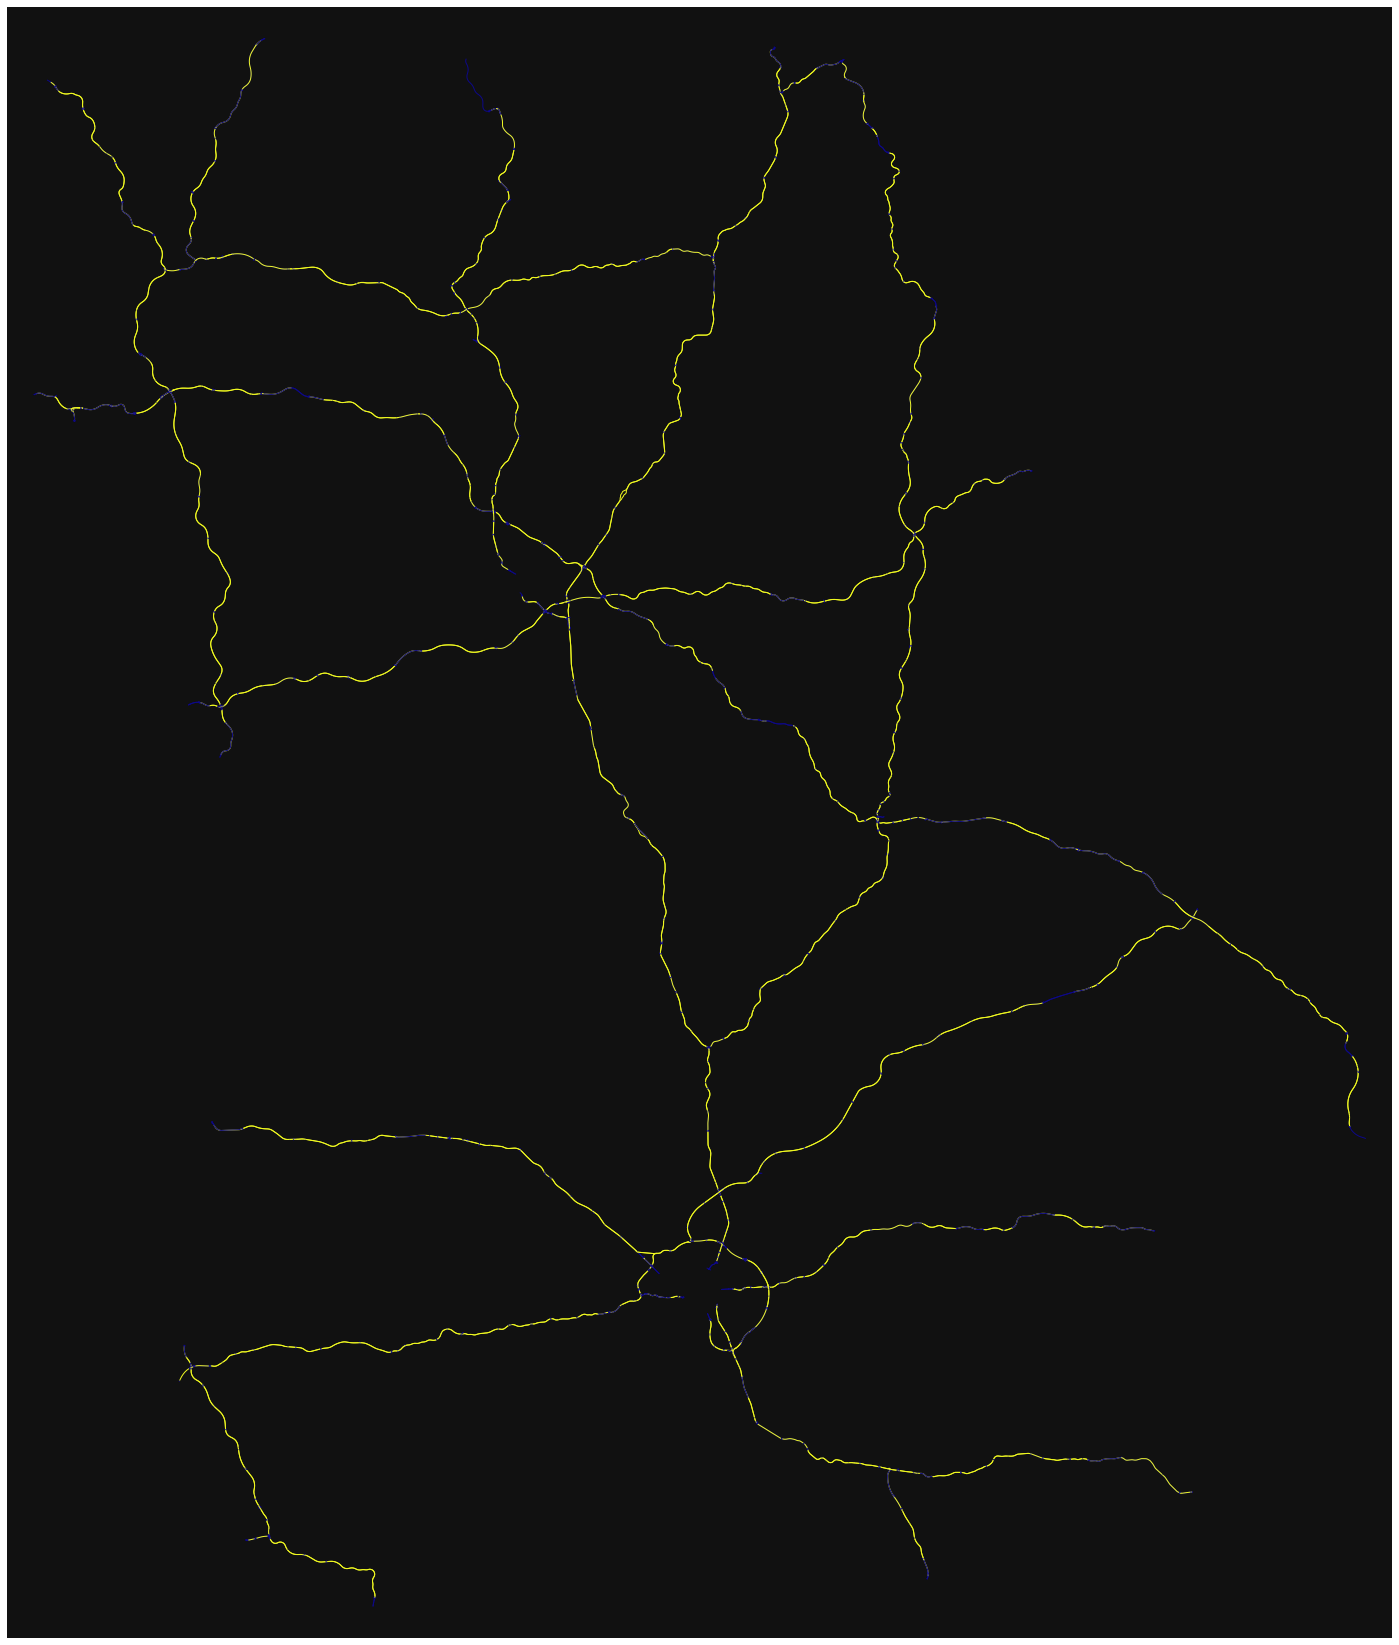

In [64]:
ec = ox.plot.get_edge_colors_by_attr(G, attr='visited', cmap='plasma', na_color="red")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(30,30))
#fig.savefig("test.png", dpi=1000)

In [65]:
motorway_edges_total = 0
motorway_edges_visited = 0
for e, visited in nx.get_edge_attributes(G,"visited").items():
    if G.edges[e]["highway"] == "motorway":
        motorway_edges_total += 1
        if visited:
            motorway_edges_visited += 1
            
pct_visited = motorway_edges_visited/motorway_edges_total * 100
print("Percentage of edges visited by logic: ", pct_visited)

Percentage of edges visited by logic:  83.68183681836818


In [66]:
motorway_length_total = 0
motorway_length_visited = 0
for e, visited in nx.get_edge_attributes(G,"visited").items():
    if G.edges[e]["highway"] == "motorway":
        motorway_length_total +=  G.edges[e]["length"]
        if visited:
            motorway_length_visited += G.edges[e]["length"]
            
pct_visited = motorway_length_visited/motorway_length_total * 100
print("Percentage of motorway network visited by logic: ", pct_visited)
print("Total Motorway Length:", motorway_length_total, "Length of motorway visited: ", motorway_length_visited)

Percentage of motorway network visited by logic:  84.85314300131061
Total Motorway Length: 4591449.342000011 Length of motorway visited:  3895989.076000005


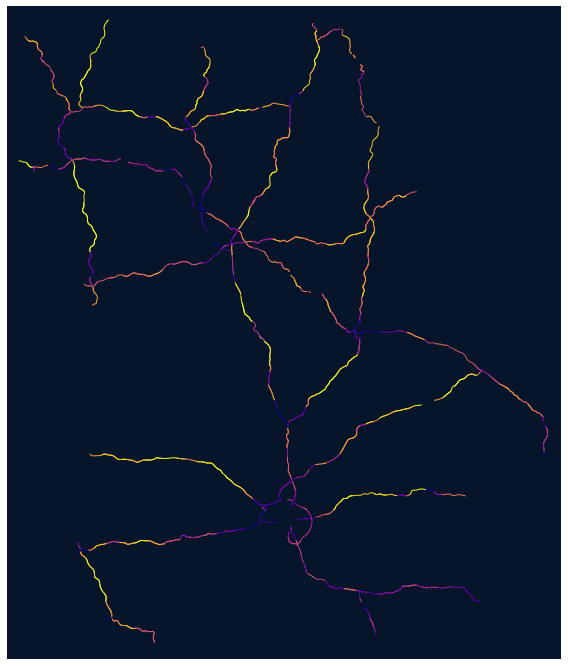

In [67]:
reqAttr = "travelSpeed"
reqTime = "15:30"

ec, bin_colors, intervals = get_edge_colors_by_TomTom_Attribute(G, cmap="plasma", requestedAttribute=reqAttr, requestedTime=reqTime, na_color="none", num_bins=10, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12), bgcolor = "#061529")

fontsize = 8
custom_patches = []
for idx, c in enumerate(bin_colors):
    label_str = str(round(intervals[idx],2)) + " km/h" + " - " + str(round(intervals[idx+1],2)) + " km/h"
    custom_patches.append(mpatches.Patch(color=c, label=label_str))

# for reference: https://towardsdatascience.com/making-artistic-maps-with-python-9d37f5ea8af0
l = ax.legend(handles=custom_patches, frameon=True, ncol=1,
              facecolor = '#061529', framealpha = 0.9,
              loc='upper right',  fontsize = fontsize, prop={'family':"Georgia", 'size':fontsize})
# Legend font color
for text in l.get_texts():
    text.set_color("w")
    
# Save figure
fig.suptitle(f'Bavarian Motorway Network "{reqAttr}" at {reqTime}', fontsize=20, color="black", y=0.92)
fname = "Network_{}_{}.png".format(reqAttr, reqTime.replace(":", "_"))
fig.savefig(fname, dpi=300, bbox_inches='tight', format="png", facecolor=fig.get_facecolor(), transparent=False)

## Analysis ungewichtet

In [68]:
def get_edge_TomTom_Attribute(requestedTime="16:00", requestedAttribute="travelSpeed"):

    out = {}
    
    edge_info = {k:v for k,v in nx.get_edge_attributes(G, "tomtomData").items()}
    for edge, data in edge_info.items():
        if not bool(data):
            out.update({edge: None})
        else:
            if requestedTime in data:
                out.update({edge: data[requestedTime][requestedAttribute]})
            else:
                out.update({edge: None})
    
    return out

In [69]:
def getSpeedLimitFromList(l):
    int_speeds = []
    for val in l:
        if val != "none" and val != "signals":
            int_speeds.append(int(val))

    if len(int_speeds) > 0:
        speedlimit = max(int_speeds)
    else:
        return 10000
    
    return speedlimit

In [70]:
motorway_length_total = 0
motorway_length_unrestricted = 0
for e, maxspeed in nx.get_edge_attributes(G,"maxspeed").items():
    if G.edges[e]["highway"] == "motorway":
        if maxspeed == "none":
            motorway_length_unrestricted += G.edges[e]["length"]
        
        motorway_length_total +=  G.edges[e]["length"]
            
pct_unrestricted = motorway_length_unrestricted/motorway_length_total * 100
print("Percentage of motorway network that is unrestricted: ", pct_unrestricted)
print("Total Motorway Length:", motorway_length_total, "Length of motorway unrestricted: ", motorway_length_unrestricted) 

Percentage of motorway network that is unrestricted:  65.20450095054801
Total Motorway Length: 4570773.791000012 Length of motorway unrestricted:  2980350.240000002


In [71]:
threshold = 120

motorway_length_total = 0
motorway_length_under_threshold = 0
motorway_length_above_threshold = 0

for e, speedlimit in nx.get_edge_attributes(G,"maxspeed").items():
    if G.edges[e]["highway"] == "motorway":
        
        if speedlimit == "none":
            speedlimit = 10000
        if speedlimit == "signals":
            speedlimit = 120 # assumption
        if isinstance(speedlimit, list):
            speedlimit = getSpeedLimitFromList(speedlimit)
    
        if int(speedlimit) <= threshold:
            motorway_length_under_threshold += G.edges[e]["length"]
        else:
            motorway_length_above_threshold += G.edges[e]["length"]


        motorway_length_total +=  G.edges[e]["length"]
            
pct_under_threshold = motorway_length_under_threshold/motorway_length_total * 100
pct_above_threshold = motorway_length_above_threshold/motorway_length_total * 100
print(f"Percentage of motorway network where speedlimit is under or at threshold of {threshold} km/h: ", pct_under_threshold)
print(f"Percentage of motorway network that would be affected by speedlimit of {threshold} km/h: ", pct_above_threshold)
print("Total Motorway Length:", motorway_length_total, f"Length of motorway where speedlimit is under or at threshold of {threshold} km/h: ", motorway_length_under_threshold) 

Percentage of motorway network where speedlimit is under or at threshold of 120 km/h:  30.152992666444483
Percentage of motorway network that would be affected by speedlimit of 120 km/h:  69.84700733355528
Total Motorway Length: 4570773.791000012 Length of motorway where speedlimit is under or at threshold of 120 km/h:  1378225.0860000001


Percentage of motorway network where historicTravelSpeed is externally forced under speedlimit at 12:30:  70.52809671973259
Percentage of motorway network that is not externally forced under speedLimit:  29.47190328026724
Percentage of motorway network that is not externally forced under speedLimit but would be restricted by threshold of 120km/h:  11.440768369200061
Total Motorway Length: 3780393.904000003 Length of motorway where historicTravelSpeed is forced under speed limit at 12:30:  2666239.8689999967


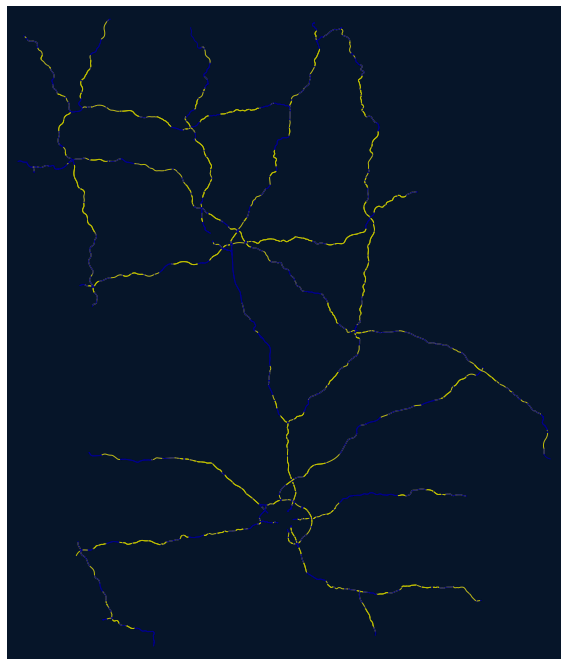

In [72]:
reqTime = "12:30"
thresholdAttribute = "historicTravelSpeed"
threshold = 120

edgesForcedUnderSpeedlimit = []
edgesPotentiallyRestricted = []

motorway_length_total = 0
motorway_length_where_speed_externally_forced_under_limit = 0
motorway_length_where_speed_not_externally_decreased = 0
motorway_length_above_speedLimit = 0
motorway_length_restricted = 0

for e, speedlimit in nx.get_edge_attributes(G,"maxspeed").items():
    if G.edges[e]["highway"] == "motorway":
        if G.edges[e]["tomtomData"] is None or reqTime not in G.edges[e]["tomtomData"]:
            continue
        travelSpeed = G.edges[e]["tomtomData"][reqTime][thresholdAttribute]
        noTrafficTravelSpeed = G.edges[e]["tomtomData"][reqTime]["noTrafficTravelSpeed"]
        trafficDelay = G.edges[e]["tomtomData"][reqTime]["historicTrafficTravelTimeInSeconds"] - G.edges[e]["tomtomData"][reqTime]["noTrafficTravelTimeInSeconds"]
        
        if speedlimit == "none":
            speedlimit = 10000
        if speedlimit == "signals":
            speedlimit = 120 # assumption
        if isinstance(speedlimit, list):
            speedlimit = getSpeedLimitFromList(speedlimit)
        
        n1,n2, _ = e
        if int(speedlimit) > travelSpeed and trafficDelay > 0:
            motorway_length_where_speed_externally_forced_under_limit += G.edges[e]["length"]
            edgesForcedUnderSpeedlimit.append((n1,n2))
        else:
            motorway_length_where_speed_not_externally_decreased += G.edges[e]["length"]
            if int(speedlimit) > threshold:
                edgesPotentiallyRestricted.append((n1,n2))
                motorway_length_restricted += G.edges[e]["length"]

        motorway_length_total +=  G.edges[e]["length"]          

pct_under_speedLimit = motorway_length_where_speed_externally_forced_under_limit/motorway_length_total * 100
pct_above_speedLimit = motorway_length_where_speed_not_externally_decreased/motorway_length_total * 100
pct_that_would_be_restricted = motorway_length_restricted/motorway_length_total * 100
print(f"Percentage of motorway network where {thresholdAttribute} is externally forced under speedlimit at {reqTime}: ", pct_under_speedLimit)
print("Percentage of motorway network that is not externally forced under speedLimit: ", pct_above_speedLimit)
print(f"Percentage of motorway network that is not externally forced under speedLimit but would be restricted by threshold of {threshold}km/h: ", pct_that_would_be_restricted)
print("Total Motorway Length:", motorway_length_total, f"Length of motorway where {thresholdAttribute} is forced under speed limit at {reqTime}: ", motorway_length_where_speed_externally_forced_under_limit) 

plotRelevantEdges(edgesForcedUnderSpeedlimit)

In [73]:
def calculateEnergyConsumptionFactor(kmh, cartype="mini", fueltype="petroleum"):
    '''
    Data Source: COPERT
    '''
    
    cartype = cartype.lower()
    fueltype = fueltype.lower()
    
    if fueltype == "benzin":
        fueltype = "petroleum"
    
    ### PETROLEUM CARS
    
    if cartype == "mini" and fueltype == "petroleum":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.0050823704040405, -0.2720371338060150, 17.9186136039889000, 0.0000000000003375, 0.0008372940477115, 0.0971261095345315, 3.7213068787177500
        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    
    if cartype == "small" and fueltype == "petroleum":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.004797387395636090, -0.253329624090869000, 20.951609322668900000, 0.000000000000254117, 0.000800882509437353, 0.091328707216536800, 3.512642585251470000
        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    if cartype == "medium" and fueltype == "petroleum":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.00013172300677853800000, 0.00548595929528390000000, 2.61919505125660000000000, 0.00000000172774612390592, -0.00008504150126997990000, 0.02358438406740600000000, 0.34429757783387900000000
        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    

    if (cartype == "large" or cartype == "SUV" or cartype == "Executive") and fueltype == "petroleum":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.00000000000069991943473, -0.00156189755234097000000, 3.24524613527012000000000, 0.00000000285012757206809, -0.00010820134286967400000, 0.01893523507065330000000, 0.26009938300687900000000
        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    
    ### DIESEL CARS
    
    if cartype == "mini" and fueltype == "diesel":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.00921573924975886, 0.11073457438445200, 18.21292341849570000, -0.00000000000655600, 0.00129254380976794, 0.63134153084374500, 0.85316423086964100

        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    if (cartype == "small" or cartype == "medium") and fueltype == "diesel":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = -0.00129911063069031000000, 0.22162498920771300000000, 16.43591461206050000000000, 0.00000000566298857668099, -0.00184467928314896000000, 0.29234727596213400000000, 2.37716402519569000000000

        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    if (cartype == "large" or cartype == "SUV" or cartype == "Executive") and fueltype == "diesel":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.000702861932235801, 0.013172543727278600, 13.711782089412000000, 0.000000000036243644, -0.000547098595260300, 0.118483099395406000, 1.647887335126100000

        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)

In [74]:
def plotSingleECF(cartype, fueltype, minspeed=10, maxspeed=130, stepsize=5):

    x = [x for x in range(minspeed, maxspeed, stepsize)]
    y = [calculateEnergyConsumptionFactor(y, cartype=cartype, fueltype=fueltype) for y in x]

    # Plot
    plt.plot(x, y, "-o", alpha=0.5)
    plt.title(f'ECF for {fueltype} vehicles of category {cartype}')
    plt.xlabel('Velocity [km/h]')
    plt.ylabel('Energy Conversion Factor [MJ/km]')
    plt.show()

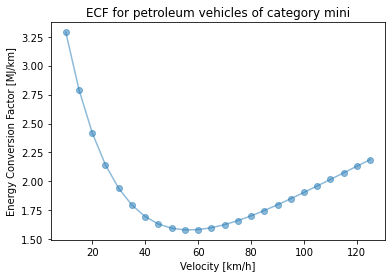

In [75]:
plotSingleECF(cartype="mini", fueltype="petroleum")

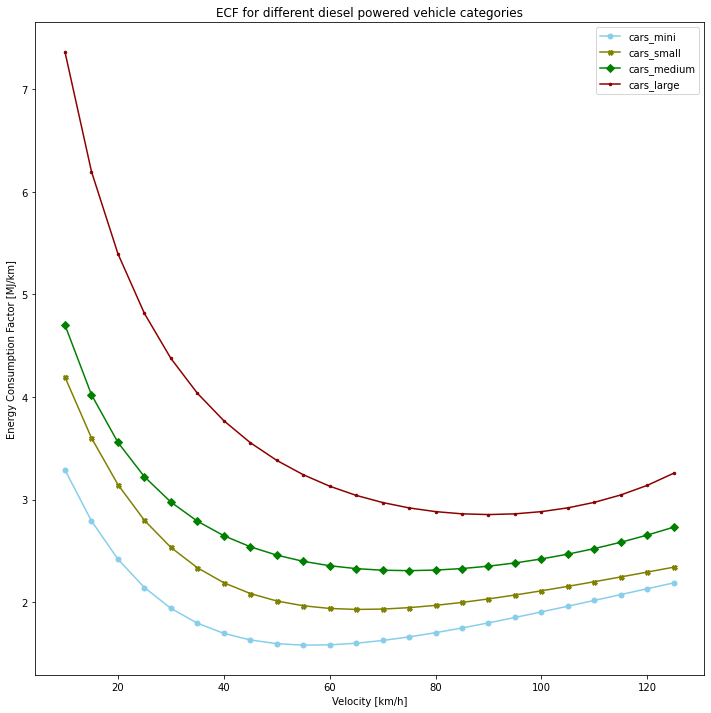

In [76]:
# DIESEL
minspeed=10
maxspeed=130
stepsize=5

fueltype = "petroleum"

# Data
df=pd.DataFrame({'x': range(minspeed,maxspeed, stepsize), 
                 'cars_mini': [calculateEnergyConsumptionFactor(x, cartype="mini", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)], 
                 'cars_small': [calculateEnergyConsumptionFactor(x, cartype="small", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)],
                 'cars_medium': [calculateEnergyConsumptionFactor(x, cartype="medium", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)],
                 'cars_large': [calculateEnergyConsumptionFactor(x, cartype="large", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)]
                })
 
# multiple line plot
fig, ax = plt.subplots(figsize=(12,12))

ax.plot( 'x', 'cars_mini', data=df, marker='o', markersize=5, color='skyblue')
ax.plot( 'x', 'cars_small', data=df, marker='X', markersize=5, color='olive')
ax.plot( 'x', 'cars_medium', data=df, marker='D', markersize=5, color='green')
ax.plot( 'x', 'cars_large', data=df, marker='.', markersize=5, color='darkred')

    
plt.legend(loc=1)

plt.title(f'ECF for different diesel powered vehicle categories')
plt.xlabel('Velocity [km/h]')
plt.ylabel('Energy Consumption Factor [MJ/km]')
plt.show()

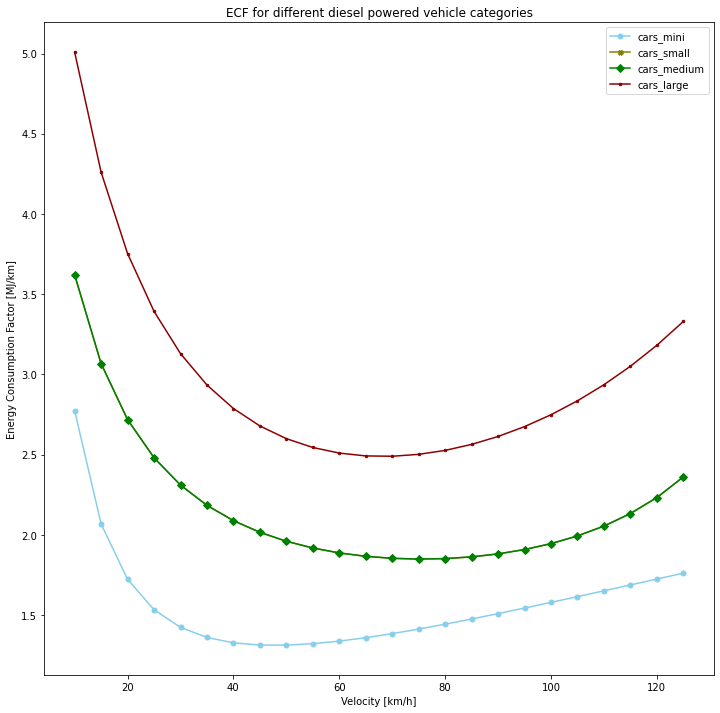

In [77]:
# DIESEL
minspeed=10
maxspeed=130
stepsize=5

fueltype = "diesel"

# Data
df=pd.DataFrame({'x': range(minspeed,maxspeed, stepsize), 
                 'cars_mini': [calculateEnergyConsumptionFactor(x, cartype="mini", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)], 
                 'cars_small': [calculateEnergyConsumptionFactor(x, cartype="small", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)],
                 'cars_medium': [calculateEnergyConsumptionFactor(x, cartype="medium", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)],
                 'cars_large': [calculateEnergyConsumptionFactor(x, cartype="large", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)]
                })
 
# multiple line plot
fig, ax = plt.subplots(figsize=(12,12))

ax.plot( 'x', 'cars_mini', data=df, marker='o', markersize=5, color='skyblue')
ax.plot( 'x', 'cars_small', data=df, marker='X', markersize=5, color='olive')
ax.plot( 'x', 'cars_medium', data=df, marker='D', markersize=5, color='green')
ax.plot( 'x', 'cars_large', data=df, marker='.', markersize=5, color='darkred')

    
plt.legend(loc=1)

plt.title(f'ECF for different diesel powered vehicle categories')
plt.xlabel('Velocity [km/h]')
plt.ylabel('Energy Consumption Factor [MJ/km]')
plt.show()

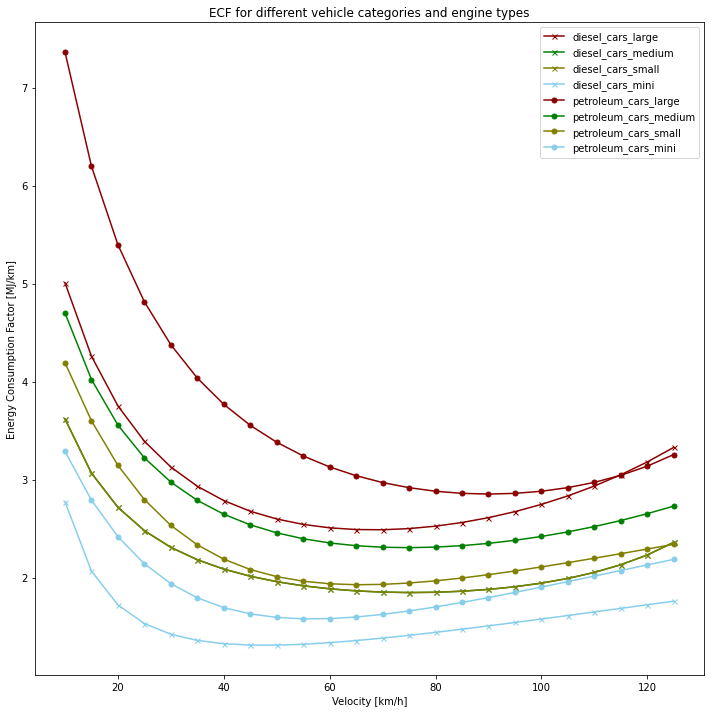

In [78]:
# BOTH
minspeed=10
maxspeed=130
stepsize=5



# Data
df=pd.DataFrame({'x': range(minspeed,maxspeed, stepsize), 
                 'diesel_cars_mini': [calculateEnergyConsumptionFactor(x, cartype="mini", fueltype="diesel") for x in range(minspeed,maxspeed, stepsize)], 
                 'diesel_cars_small': [calculateEnergyConsumptionFactor(x, cartype="small", fueltype="diesel") for x in range(minspeed,maxspeed, stepsize)],
                 'diesel_cars_medium': [calculateEnergyConsumptionFactor(x, cartype="medium", fueltype="diesel") for x in range(minspeed,maxspeed, stepsize)],
                 'diesel_cars_large': [calculateEnergyConsumptionFactor(x, cartype="large", fueltype="diesel") for x in range(minspeed,maxspeed, stepsize)],
                 'petroleum_cars_mini': [calculateEnergyConsumptionFactor(x, cartype="mini", fueltype="petroleum") for x in range(minspeed,maxspeed, stepsize)], 
                 'petroleum_cars_small': [calculateEnergyConsumptionFactor(x, cartype="small", fueltype="petroleum") for x in range(minspeed,maxspeed, stepsize)],
                 'petroleum_cars_medium': [calculateEnergyConsumptionFactor(x, cartype="medium", fueltype="petroleum") for x in range(minspeed,maxspeed, stepsize)],
                 'petroleum_cars_large': [calculateEnergyConsumptionFactor(x, cartype="large", fueltype="petroleum") for x in range(minspeed,maxspeed, stepsize)]
                })
 
# multiple line plot
fig, ax = plt.subplots(figsize=(12,12))

ax.plot( 'x', 'diesel_cars_large', data=df, marker='x', markersize=5, color='darkred')
ax.plot( 'x', 'diesel_cars_medium', data=df, marker='x', markersize=5, color='green')
ax.plot( 'x', 'diesel_cars_small', data=df, marker='x', markersize=5, color='olive')
ax.plot( 'x', 'diesel_cars_mini', data=df, marker='x', markersize=5, color='skyblue')


ax.plot( 'x', 'petroleum_cars_large', data=df, marker='o', markersize=5, color='darkred')
ax.plot( 'x', 'petroleum_cars_medium', data=df, marker='o', markersize=5, color='green')
ax.plot( 'x', 'petroleum_cars_small', data=df, marker='o', markersize=5, color='olive')
ax.plot( 'x', 'petroleum_cars_mini', data=df, marker='o', markersize=5, color='skyblue')




    
plt.legend(loc=1)

plt.title(f'ECF for different vehicle categories and engine types')
plt.xlabel('Velocity [km/h]')
plt.ylabel('Energy Consumption Factor [MJ/km]')
plt.show()

In [79]:
def calculateCO2eFromECF(ecf, numcars=1, fueltype="diesel"):
    '''
    Returns grams of CO2e generated per kilometer
    '''
    
    # Source: DIN EN 16258:2013-03
    CO2eGramsPerMJ_diesel = 71.0 # 1 Megajoule of Diesel E5 produces 71.0 grams of CO2e Tank-To-Wheel
    CO2eGramsPerMJ_petroleum = 75.2
    
    fueltype = fueltype.lower()
    
    if fueltype == "diesel":
        return CO2eGramsPerMJ_diesel * ecf * numcars
    elif fueltype == "petroleum" or fueltype == "benzin":
        return CO2eGramsPerMJ_petroleum * ecf * numcars

In [80]:
distributionData = pd.read_csv("data/Verteilung_Fahrzeugklassen.csv", sep=";", decimal=",")

In [81]:
distributionData

,Typ,COPERT Typ,Anzahl 2020 Benzin,Anzahl 2020 Diesel,Anzahl 2020 Gesamt,Anteil in % 2020 Benzin,Anteil in % 2020 Diesel
0,MINIS,Mini,2.203678e+06,1.076121e+06,3.279800e+06,0.048262,0.023568
1,KLEINWAGEN,Small,5.886766e+06,2.874682e+06,8.761447e+06,0.128924,0.062957
2,KOMPAKTKLASSE,Medium,7.895537e+06,3.855624e+06,1.175116e+07,0.172917,0.084441
3,MITTELKLASSE,Medium,4.142227e+06,2.022772e+06,6.164999e+06,0.090718,0.044300
4,OBERE MITTELKLASSE,Medium,1.267387e+06,6.189027e+05,1.886290e+06,0.027757,0.013554
5,OBERKLASSE,Large,1.775324e+05,8.669433e+04,2.642268e+05,0.003888,0.001899
6,SUVs,Large,2.481024e+06,1.211557e+06,3.692582e+06,0.054336,0.026534
7,GELÄNDEWAGEN,Large,1.709724e+06,8.349089e+05,2.544633e+06,0.037444,0.018285
8,SPORTWAGEN,Large,6.049298e+05,2.954051e+05,9.003349e+05,0.013248,0.006470
9,MINI-VANS,Large,1.315009e+06,6.421576e+05,1.957166e+06,0.028800,0.014064


In [82]:
distrDf_grouped = distributionData.groupby(["COPERT Typ"]).sum().iloc[:, 3:5]

In [83]:
for e in G.edges():
    if len(G.edges[(*e, 0)]["tomtomData"]) > 0:
        print(e)
        break

(266518531, 266518591)


In [84]:
def calculateAvgHistTravelSpeed(e, threshold=10000):
    avg = 0
    counter = 0
    if len(G.edges[(*e, 0)]["tomtomData"]) > 0:
        for time, data in G.edges[(*e, 0)]["tomtomData"].items():
            if data["historicTravelSpeed"] > threshold:
                avg += threshold
            else:
                avg += data["historicTravelSpeed"]
            counter += 1
    else:
        return None
    
    return avg / counter


In [85]:
def calculateEdgeCO2e(e, restricted=False, threshold=120):
    '''
    Returns the total CO2e on any given edge in kilograms
    '''
    if restricted:
        avgSpeed = calculateAvgHistTravelSpeed(e, threshold)
    else:
        avgSpeed = calculateAvgHistTravelSpeed(e)
    
    
    carsOnEdge = G.edges[(*e, 0)]["quantity_cars"]
    edgeLength = G.edges[(*e, 0)]["length"]
    
    totalCO2eOnEdge = 0
    
    if avgSpeed is not None:
        if restricted and avgSpeed > threshold:
            avgSpeed = threshold
            
        for idx, row in distrDf_grouped.iterrows():
            carsInCategoryDiesel = carsOnEdge * row["Anteil in % 2020 Diesel"]
            carsInCategoryPetroleum = carsOnEdge * row["Anteil in % 2020 Benzin"]
            
            ECF_diesel = calculateEnergyConsumptionFactor(avgSpeed, cartype=idx, fueltype="diesel")
            ECF_petroleum = calculateEnergyConsumptionFactor(avgSpeed, cartype=idx, fueltype="petroleum")
            
            gramsCO2ePerKm_diesel = calculateCO2eFromECF(ECF_diesel, numcars=carsInCategoryDiesel, fueltype="diesel")
            gramsCO2ePerKm_petroleum = calculateCO2eFromECF(ECF_diesel, numcars=carsInCategoryPetroleum, fueltype="petroleum")
            
            totalCO2eOnEdge += (gramsCO2ePerKm_diesel + gramsCO2ePerKm_petroleum) * (edgeLength / 1000)
    
    return totalCO2eOnEdge / 1000 # return in kilograms


In [86]:
calculateEdgeCO2e((266518531, 266518591), restricted=True)

1137.3205136760976

In [87]:
totalCO2e = 0
totalCO2e_restricted = 0
for e in G.edges():
    totalCO2e += calculateEdgeCO2e(e)
    totalCO2e_restricted += calculateEdgeCO2e(e, restricted=True)
    
print (totalCO2e_restricted / totalCO2e)

0.8960382822112702


In [88]:
totalCO2e - totalCO2e_restricted

2468891.682180777

## Analysis Gewichtet

In [89]:
motorway_length_total = 0
motorway_length_unrestricted = 0
motorway_flow_unrestricted = 0
flow_kilometers_unrestricted = 0
total_flow_kilometers = 0

totalCarQuantity = 0

for e, maxspeed in nx.get_edge_attributes(G,"maxspeed").items():
    if G.edges[e]["highway"] == "motorway":
        if maxspeed == "none":
            edge_car_quantity = G.edges[e]["quantity_cars"]
            motorway_flow_unrestricted += edge_car_quantity
            motorway_length_unrestricted += G.edges[e]["length"]
            flow_kilometers_unrestricted += G.edges[e]["length"] * edge_car_quantity
        
        motorway_length_total +=  G.edges[e]["length"]
        total_flow_kilometers += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
        totalCarQuantity += G.edges[e]["quantity_cars"]
            
pct_unrestricted = motorway_length_unrestricted/motorway_length_total * 100
pct_flow_unrestricted = motorway_flow_unrestricted/totalCarQuantity * 100
pct_flow_kilometers_unrestricted = flow_kilometers_unrestricted/total_flow_kilometers * 100
print("Percentage of motorway network that is unrestricted: ", pct_unrestricted)
print("Percentage of network flow that is unrestricted: ", pct_flow_unrestricted)
print("Percentage of flow kilometers unrestricted: ", pct_flow_kilometers_unrestricted)

Percentage of motorway network that is unrestricted:  65.20450095054801
Percentage of network flow that is unrestricted:  64.40752791164309
Percentage of flow kilometers unrestricted:  64.87322142976946


In [90]:
threshold = 120

motorway_length_total = 0
total_flow_kilometers = 0

motorway_length_under_threshold = 0
motorway_flow_under_threshold = 0
flow_kilometers_under_threshold = 0

motorway_length_above_threshold = 0
motorway_flow_above_threshold = 0
flow_kilometers_above_threshold = 0

totalCarQuantity = 0

for e, speedlimit in nx.get_edge_attributes(G,"maxspeed").items():
    if G.edges[e]["highway"] == "motorway":
        
        if speedlimit == "none":
            speedlimit = 10000
        if speedlimit == "signals":
            speedlimit = 120 # assumption
        if isinstance(speedlimit, list):
            speedlimit = getSpeedLimitFromList(speedlimit)
    
        if int(speedlimit) <= threshold:
            motorway_length_under_threshold += G.edges[e]["length"]
            motorway_flow_under_threshold += G.edges[e]["quantity_cars"]
            flow_kilometers_under_threshold += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
            
        else:
            motorway_length_above_threshold += G.edges[e]["length"]
            motorway_flow_above_threshold += G.edges[e]["quantity_cars"]
            flow_kilometers_above_threshold += G.edges[e]["length"] * G.edges[e]["quantity_cars"]


        motorway_length_total +=  G.edges[e]["length"]
        total_flow_kilometers += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
        totalCarQuantity += G.edges[e]["quantity_cars"]
            
pct_under_threshold = motorway_length_under_threshold/motorway_length_total * 100
pct_above_threshold = motorway_length_above_threshold/motorway_length_total * 100

pct_flow_under_threshold = motorway_flow_under_threshold / totalCarQuantity * 100
pct_flow_above_threshold = motorway_flow_above_threshold / totalCarQuantity * 100

pct_flow_kilometers_under_threshold = flow_kilometers_under_threshold / total_flow_kilometers * 100
pct_flow_kilometers_above_threshold = flow_kilometers_above_threshold / total_flow_kilometers * 100

print(f"Percentage of motorway network where speedlimit is under or at threshold of {threshold} km/h: ", pct_under_threshold)
print(f"Percentage of motorway network that would be affected by speedlimit of {threshold} km/h: ", pct_above_threshold)
print("---"*30)

print(f"Percentage of motorway network flow where speedlimit is under or at threshold of {threshold} km/h: ", pct_flow_under_threshold)
print(f"Percentage of motorway network flow where speedlimit is above threshold of {threshold} km/h: ", pct_flow_above_threshold)
print("---"*30)

print(f"Percentage of flow kilometers where speedlimit is under or at threshold of {threshold} km/h: ", pct_flow_kilometers_under_threshold)
print(f"Percentage of flow kilometers that would be affected by speedlimit of {threshold} km/h: ", pct_flow_kilometers_above_threshold)


Percentage of motorway network where speedlimit is under or at threshold of 120 km/h:  30.152992666444483
Percentage of motorway network that would be affected by speedlimit of 120 km/h:  69.84700733355528
------------------------------------------------------------------------------------------
Percentage of motorway network flow where speedlimit is under or at threshold of 120 km/h:  32.76941005667213
Percentage of motorway network flow where speedlimit is above threshold of 120 km/h:  67.23058994332789
------------------------------------------------------------------------------------------
Percentage of flow kilometers where speedlimit is under or at threshold of 120 km/h:  31.18959167693437
Percentage of flow kilometers that would be affected by speedlimit of 120 km/h:  68.81040832306572


Percentage of motorway network where historicTravelSpeed is externally forced under speedlimit at 7:30:  71.34483423800904
Percentage of motorway network that is not externally forced under speedLimit:  28.655165761990826
Percentage of motorway network that is not externally forced under speedLimit but would be restricted by threshold of 120km/h:  12.636912746763407
------------------------------------------------------------------------------------------
Percentage of motorway flow where historicTravelSpeed is externally forced under speedlimit at 7:30:  73.86694377166249
Percentage of motorway flow that is not externally forced under speedLimit:  26.133056228337516
Percentage of motorway flow that is not externally forced under speedLimit but would be restricted by threshold of 120km/h:  11.90876686481383
------------------------------------------------------------------------------------------
Percentage of kilometers driven where historicTravelSpeed is externally forced under speed

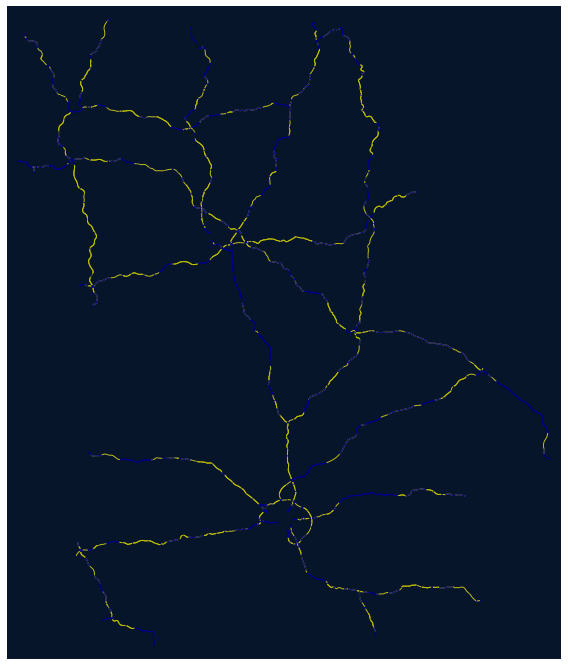

In [91]:
reqTime = "7:30"
thresholdAttribute = "historicTravelSpeed"
threshold = 120

edgesForcedUnderSpeedlimit = []
edgesPotentiallyRestricted = []

motorway_length_total = 0
total_flow_kilometers = 0
totalCarQuantity = 0

motorway_length_where_speed_externally_forced_under_limit = 0
motorway_flow_where_speed_externally_forced_under_limit = 0
flow_kilometers_where_speed_externally_forced_under_limit = 0

motorway_length_where_speed_not_externally_decreased = 0
motorway_flow_where_speed_not_externally_decreased = 0
flow_kilometers_where_speed_not_externally_decreased = 0

motorway_length_restricted = 0
motorway_flow_restricted = 0
flow_kilometers_restricted = 0

for e, speedlimit in nx.get_edge_attributes(G,"maxspeed").items():
    if G.edges[e]["highway"] == "motorway":
        if G.edges[e]["tomtomData"] is None or reqTime not in G.edges[e]["tomtomData"]:
            continue
        travelSpeed = G.edges[e]["tomtomData"][reqTime][thresholdAttribute]
        noTrafficTravelSpeed = G.edges[e]["tomtomData"][reqTime]["noTrafficTravelSpeed"]
        trafficDelay = G.edges[e]["tomtomData"][reqTime]["historicTrafficTravelTimeInSeconds"] - G.edges[e]["tomtomData"][reqTime]["noTrafficTravelTimeInSeconds"]
        
        if speedlimit == "none":
            speedlimit = 10000
        if speedlimit == "signals":
            speedlimit = 120 # assumption
        if isinstance(speedlimit, list):
            speedlimit = getSpeedLimitFromList(speedlimit)
        
        n1,n2, _ = e
        if int(speedlimit) > travelSpeed and trafficDelay > 0:
            motorway_length_where_speed_externally_forced_under_limit += G.edges[e]["length"]
            motorway_flow_where_speed_externally_forced_under_limit += G.edges[e]["quantity_cars"]
            flow_kilometers_where_speed_externally_forced_under_limit += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
            
            edgesForcedUnderSpeedlimit.append((n1,n2))
        else:
            motorway_length_where_speed_not_externally_decreased += G.edges[e]["length"]
            motorway_flow_where_speed_not_externally_decreased += G.edges[e]["quantity_cars"]
            flow_kilometers_where_speed_not_externally_decreased += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
            
            if int(speedlimit) > threshold:
                edgesPotentiallyRestricted.append((n1,n2))
                motorway_length_restricted += G.edges[e]["length"]
                motorway_flow_restricted += G.edges[e]["quantity_cars"]
                flow_kilometers_restricted += G.edges[e]["length"] * G.edges[e]["quantity_cars"]

        motorway_length_total +=  G.edges[e]["length"]
        total_flow_kilometers += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
        totalCarQuantity += G.edges[e]["quantity_cars"]

pct_under_speedLimit = motorway_length_where_speed_externally_forced_under_limit/motorway_length_total * 100
pct_above_speedLimit = motorway_length_where_speed_not_externally_decreased/motorway_length_total * 100
pct_that_would_be_restricted = motorway_length_restricted/motorway_length_total * 100

pct_flow_under_speedLimit = motorway_flow_where_speed_externally_forced_under_limit/totalCarQuantity * 100
pct_flow_above_speedLimit = motorway_flow_where_speed_not_externally_decreased/totalCarQuantity * 100
pct_flow_that_would_be_restricted = motorway_flow_restricted/totalCarQuantity * 100

pct_flow_kilometers_under_speedLimit = flow_kilometers_where_speed_externally_forced_under_limit/total_flow_kilometers * 100
pct_flow_kilometers_above_speedLimit = flow_kilometers_where_speed_not_externally_decreased/total_flow_kilometers * 100
pct_flow_kilometers_that_would_be_restricted = flow_kilometers_restricted/total_flow_kilometers * 100



print(f"Percentage of motorway network where {thresholdAttribute} is externally forced under speedlimit at {reqTime}: ", pct_under_speedLimit)
print("Percentage of motorway network that is not externally forced under speedLimit: ", pct_above_speedLimit)
print(f"Percentage of motorway network that is not externally forced under speedLimit but would be restricted by threshold of {threshold}km/h: ", pct_that_would_be_restricted)
print("---"*30)

print(f"Percentage of motorway flow where {thresholdAttribute} is externally forced under speedlimit at {reqTime}: ", pct_flow_under_speedLimit)
print("Percentage of motorway flow that is not externally forced under speedLimit: ", pct_flow_above_speedLimit)
print(f"Percentage of motorway flow that is not externally forced under speedLimit but would be restricted by threshold of {threshold}km/h: ", pct_flow_that_would_be_restricted)
print("---"*30)

print(f"Percentage of kilometers driven where {thresholdAttribute} is externally forced under speedlimit at {reqTime}: ", pct_flow_kilometers_under_speedLimit)
print("Percentage of kilometers driven that is not externally forced under speedLimit: ", pct_flow_kilometers_above_speedLimit)
print(f"Percentage of kilometers driven that is not externally forced under speedLimit but would be restricted by threshold of {threshold}km/h: ", pct_flow_kilometers_that_would_be_restricted)
print("---"*30)

plotRelevantEdges(edgesForcedUnderSpeedlimit)

## Analysis CO2

In [92]:
#### WORK IN PROGRESS

# NOTE TO SELF!!! Manche Motorway_links werden betrachtet, wenn Sie für einen Autobahnwechsel auf einer Route benötigt werden. Motorway_links, welche lediglich Auffahrten darstellen, werden allerdings nicht betrachtet.